# Proyecto I
## Modelos para riesgo operacional
## Yael Fabián Olivares Cruz

### Simulación LogNormal, riesgo 1
La distribución LogNormal tiene la siguiente función de densidad
$$ f_X(x) = \frac{1}{x \sigma \sqrt{2 \pi}} exp \left\{ - \frac{(ln(x) - \mu)^2}{2 \sigma ^2} \right\} \mathbb{1}_{(0, \infty)} (x)$$
$ \mu \in \mathbb{R}, ~~~ \sigma > 0 $

In [1]:
# Instalacion de librerias
!pip install siuba
!pip install copulas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.6/208.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 2.0.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.8 MB/s eta 0:00:00


In [2]:
# Librerias
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm
import scipy.stats as stats
from siuba import *
from plotnine import *
import matplotlib.pyplot as plt
from google.colab import files # Para descargar CSV's
import statsmodels.api as sm
from scipy.stats import gumbel_r
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import GaussianKDE
from copulas.bivariate import Clayton, Gumbel, Frank
from sklearn.preprocessing import QuantileTransformer

In [3]:
# Parametros de la distribucion Lognormal
n = 100000
perdidaMedia = 650000
sdPerdida = 1.62

# Generacion de la Lognormal
np.random.seed(2024)
lognormal = np.random.lognormal(mean=np.log(perdidaMedia), sigma=np.log(sdPerdida), size = n)

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 344'. Pick better value with 'binwidth'.


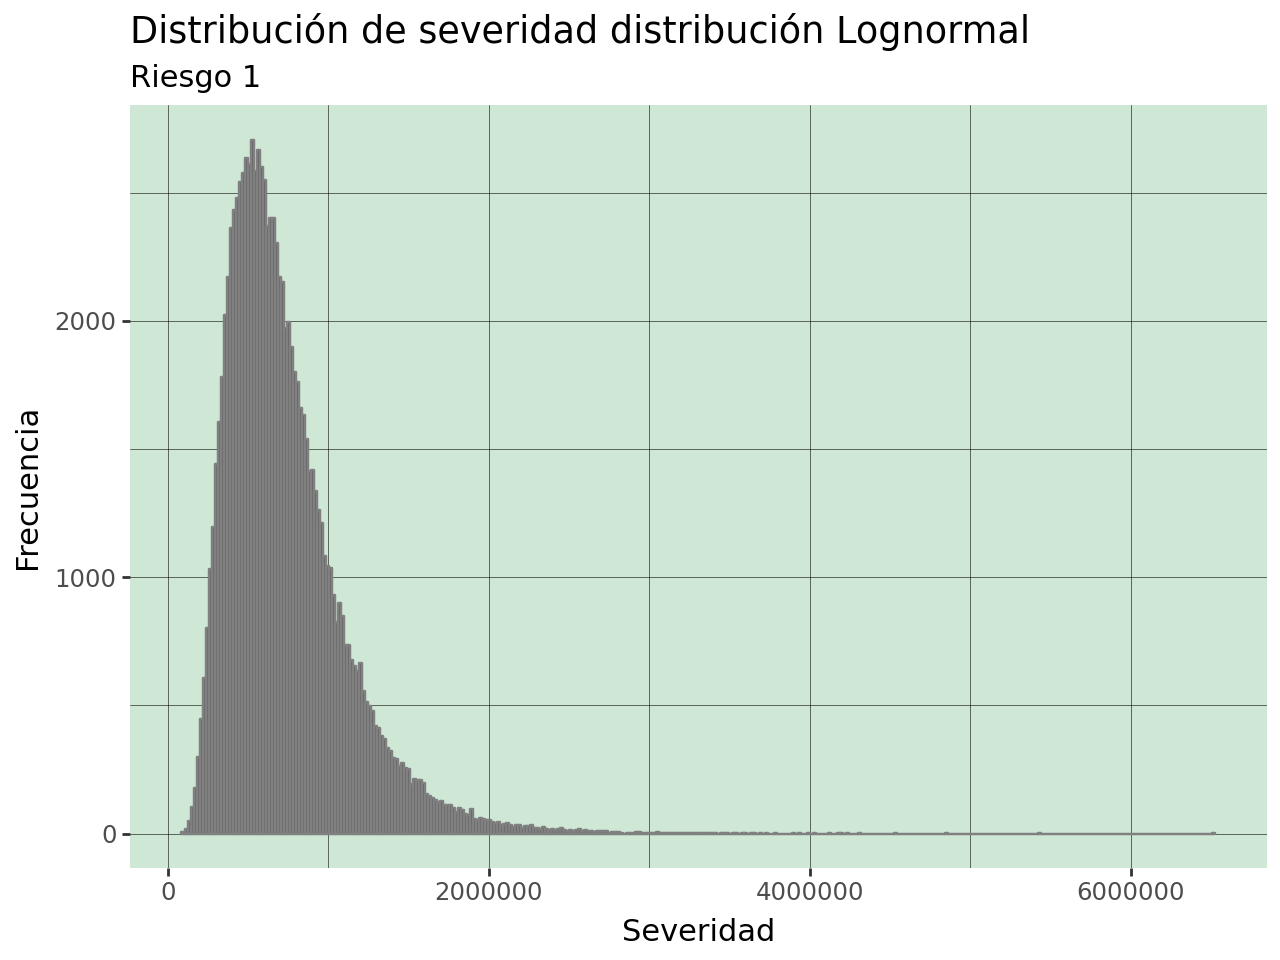

In [4]:
# Grafico de la distribucion Lognormal
(ggplot() +
 geom_histogram(mapping=aes(x=lognormal), color='grey') +
 labs(title="Distribución de severidad distribución Lognormal", subtitle='Riesgo 1', x="Severidad", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

### Simulación PERT, riesgo 2
La distribución PERT tiene la siguiente función de densidad
$$ f_X(x) = \frac{(x-a)^{\alpha - 1}(c-x)^{\beta - 1}}{B(\alpha, \beta) (c-a)^{\alpha + \beta - 1}}, $$
$ \alpha = 1 + \lambda \frac{b-a}{c-a} $\
$ \beta = 1 + \lambda \frac{c-b}{c-a} $\
El valor clásico de $\lambda$ es $4$

Para simular una distribución Pert se genera una muestra de una distribución $Beta(\alpha, \beta)$ y se aplica la transformación $min+(max-min)*Beta(\alpha,\beta)$

In [5]:
# Funcion para generar la distribucion PERT

def rpert(n, min, media, max, lamb=4):
  # Parametros alpha y beta de la distribucion beta
  valorAlpha = 1 + lamb*((media-min)/(max-min))
  valorBeta = 1 + lamb*((max-media)/(max-min))

  # Generar muestras de una distribución Pert
  np.random.seed(2024)
  rbeta = beta.rvs(valorAlpha, valorBeta, size=n)

  # Transformar las muestras Beta a la escala Pert
  return min + (max - min)*rbeta

In [6]:
# Generacion de la distribucion PERT

n = 100000
min = 65000
media = 500000
max = 10000000

min = lognormal.min()
media = lognormal.mean()
max = lognormal.max()

pert = rpert(n, min, media, max)

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 99'. Pick better value with 'binwidth'.


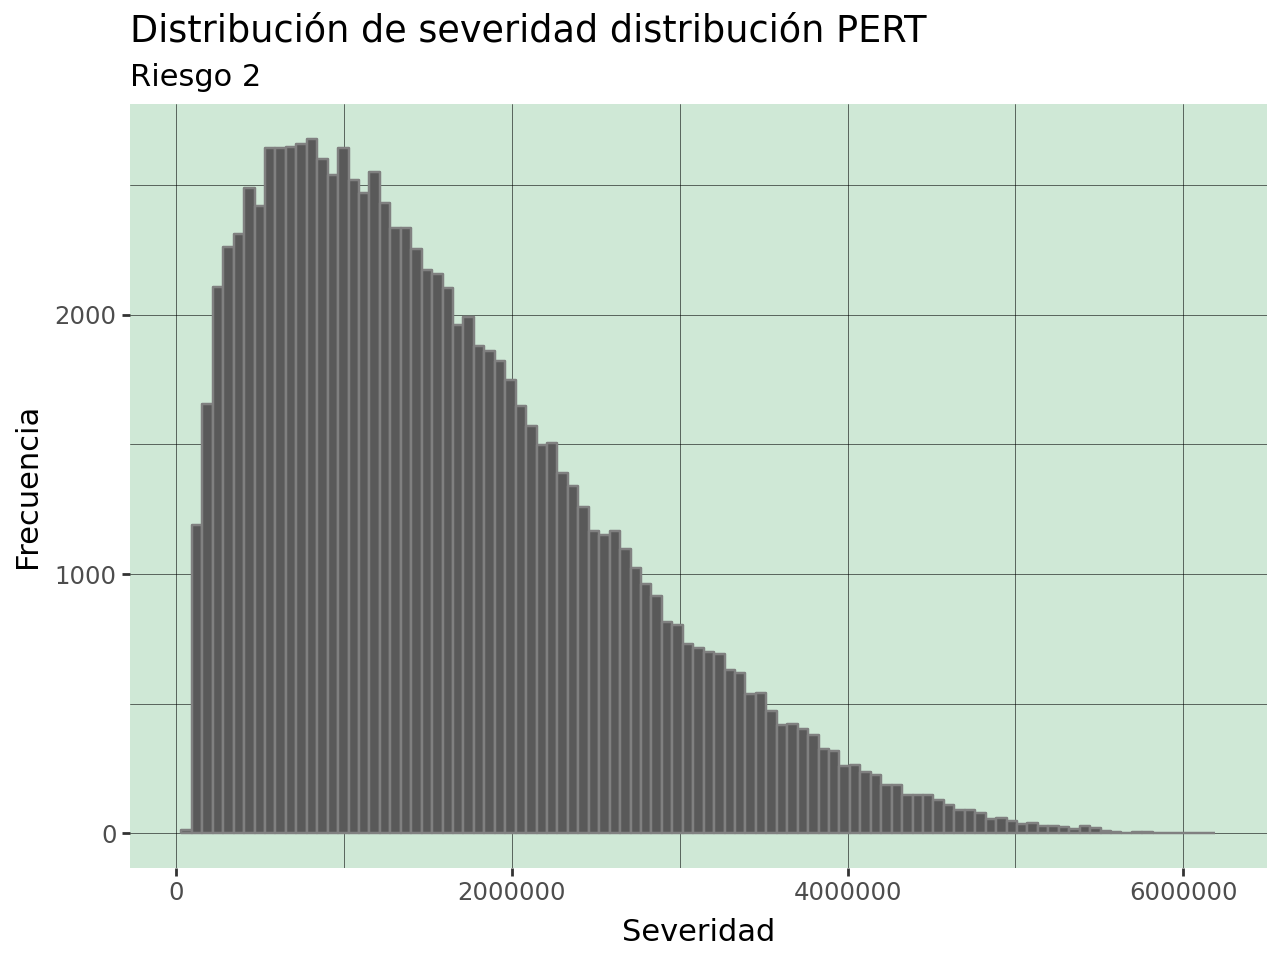

In [7]:
# Grafico de la distribucion PERT
(ggplot() +
 geom_histogram(mapping=aes(x=pert), color='grey') +
 labs(title="Distribución de severidad distribución PERT", subtitle='Riesgo 2', x="Severidad", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

### Simulación de una distribucion empírica, riesgo 3


In [16]:
# Importar los datos

tickets = pd.read_csv("export_dataframeCSV.csv")
tickets = (tickets >> select('Incident_ID', 'Impact', 'Category', 'Open_Time') >> filter(_.Category == 'incident'))
tickets['Open_Time'] = pd.to_datetime(tickets['Open_Time'], format='%d-%m-%Y %H:%M')

<ipython-input-16-41bb8997f4c3>:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


In [17]:
tickets.head()

,Incident_ID,Impact,Category,Open_Time
0,IM0000004,4,incident,2012-02-05 13:32:00
1,IM0000005,3,incident,2012-03-12 15:44:00
3,IM0000011,4,incident,2012-07-17 11:49:00
4,IM0000012,4,incident,2012-08-10 11:01:00
5,IM0000013,4,incident,2012-08-10 11:27:00


In [18]:
# Simular incidentes ficticios

noIncidentes = tickets.shape[0]

np.random.seed(2024)
parte1 = np.random.lognormal(mean=np.log(perdidaMedia), sigma=np.log(sdPerdida), size = noIncidentes) / 2
parte2 = rpert(noIncidentes, min, media, max) / 2

incidentes = parte1 + parte2

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 86'. Pick better value with 'binwidth'.


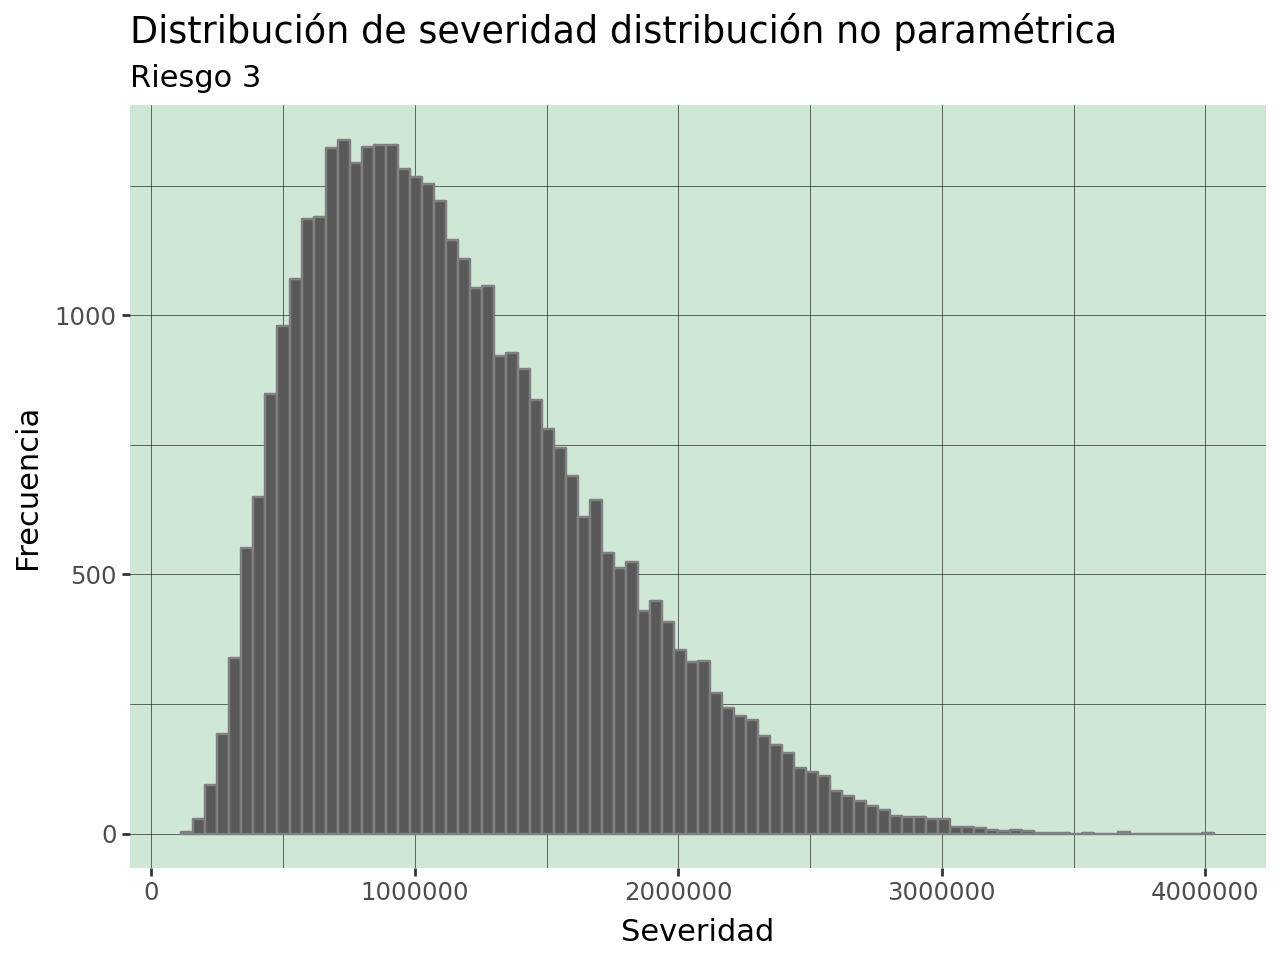

In [19]:
(ggplot() +
 geom_histogram(mapping=aes(x=incidentes), color='grey') +
 labs(title="Distribución de severidad distribución no paramétrica", subtitle='Riesgo 3', x="Severidad", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

In [20]:
# Incluir los incidentes en la base

tickets['Severidad'] = incidentes
tickets.head()

,Incident_ID,Impact,Category,Open_Time,Severidad
0,IM0000004,4,incident,2012-02-05 13:32:00,2.036414e+06
1,IM0000005,3,incident,2012-03-12 15:44:00,1.087896e+06
3,IM0000011,4,incident,2012-07-17 11:49:00,3.459975e+05
4,IM0000012,4,incident,2012-08-10 11:01:00,1.198250e+06
5,IM0000013,4,incident,2012-08-10 11:27:00,6.721282e+05


In [21]:
# Funcion para calcular la distribucion empirica

def distribucionEmpirica(eventos):
  n = len(eventos)
  eventosOrdenados = np.sort(eventos)
  CDF = np.arange(1, n+1)/n
  return eventosOrdenados, CDF

In [22]:
# Obtener la funcion de distribucion empirica

eventos = tickets['Severidad']
eventos, cdf = distribucionEmpirica(eventos)

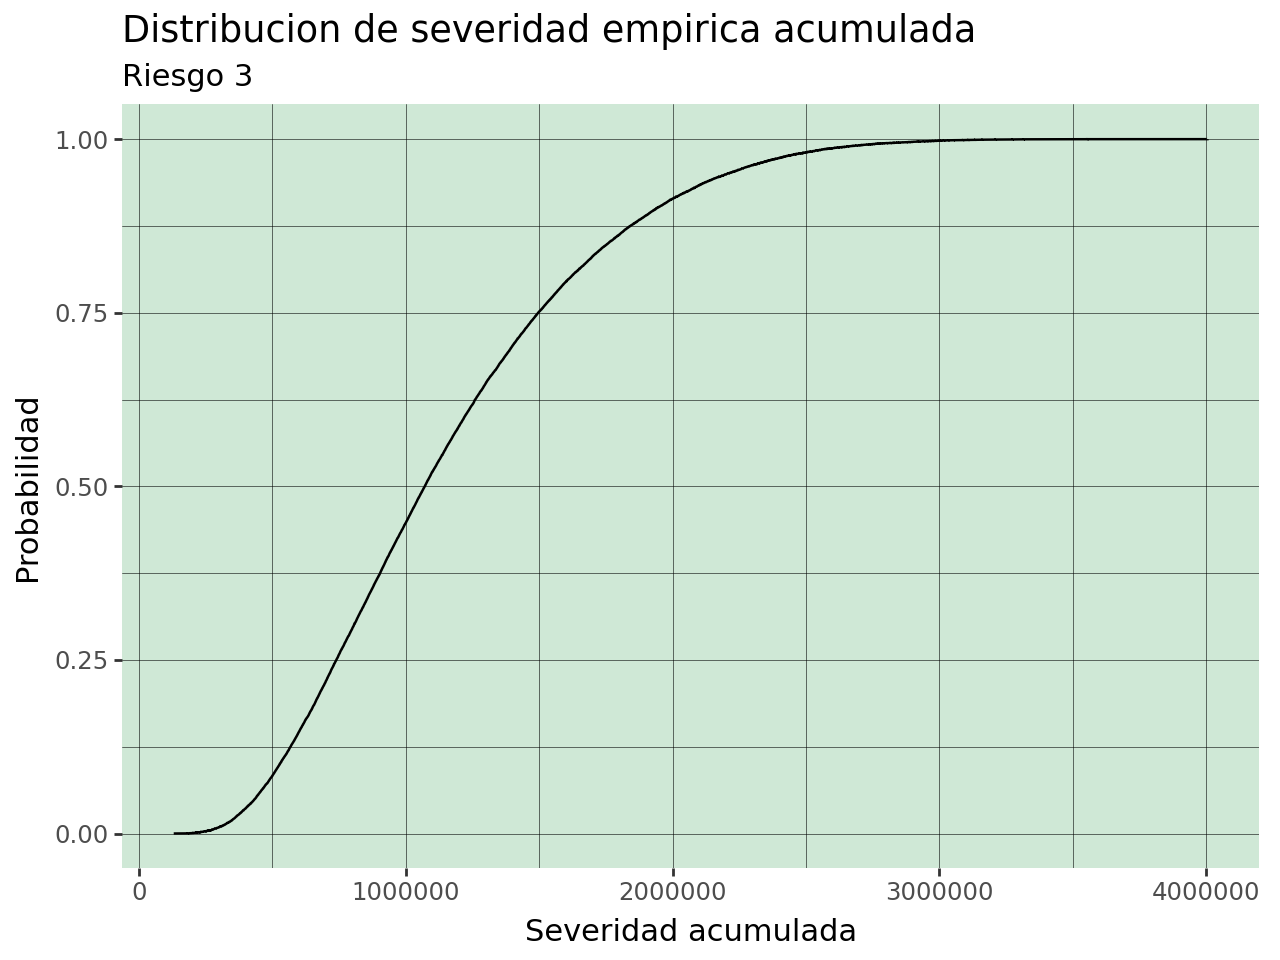

In [23]:
# Graficar la distribucion empirica acumulada

(ggplot() +
 geom_step(mapping=aes(x=eventos, y=cdf)) +
 labs(title="Distribucion de severidad empirica acumulada", subtitle='Riesgo 3', x="Severidad acumulada", y="Probabilidad") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

In [24]:
# Funcion para simular valores de los incidentes

def simulacionDistEmpirica(n):
  perdidas = [] # Lista donde se almacenaran las perdidas
  for _ in range(n):
    u = np.random.uniform(0,1)
    ubicacionU = np.searchsorted(cdf, u) # Encontrar a que altura se encontro la uniforme
    perdidaSimulada = eventos[ubicacionU] # Mapear la altura con su perdida
    perdidas.append(perdidaSimulada) # Añadir las perdidas simuladas a la lista
  return np.array(perdidas)

In [25]:
# Generacion de los numeros de que siguen la distribucion empirica

n = 100000
np.random.seed(2024)
distEmpirica = simulacionDistEmpirica(n)

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 120'. Pick better value with 'binwidth'.


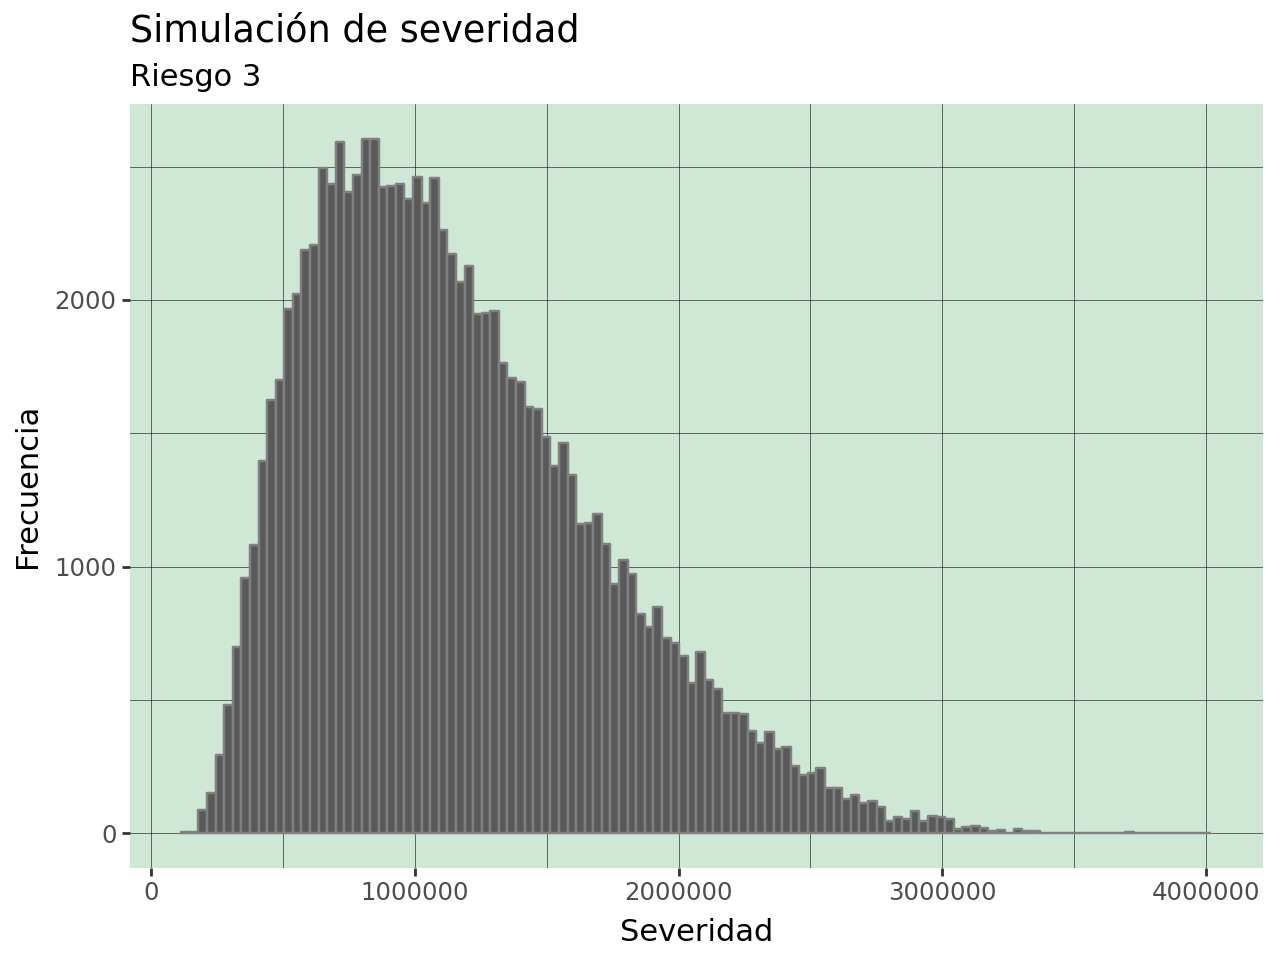

In [26]:
# Graficar la distribucion empirica de perdidas

(ggplot() +
 geom_histogram(mapping=aes(x=distEmpirica), color='grey') +
 labs(title="Simulación de severidad", subtitle='Riesgo 3', x="Severidad", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 86'. Pick better value with 'binwidth'.
/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 120'. Pick better value with 'binwidth'.


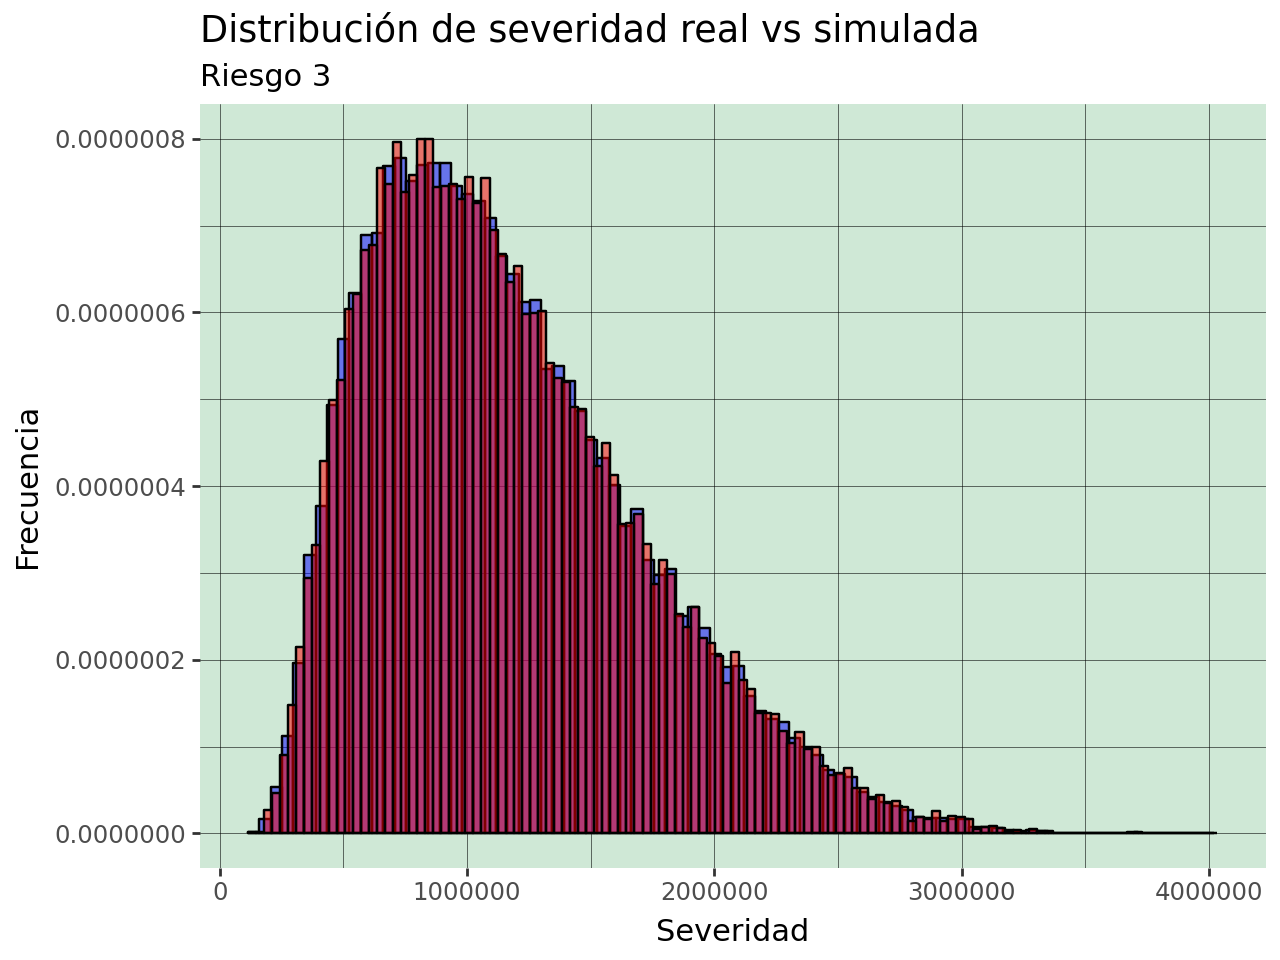

In [27]:
# Graficar la distribucion empirica de perdidas vs distribucion real de perdidas

(ggplot() +
 geom_histogram(mapping=aes(x=tickets['Severidad'], y='..density..'), fill="blue", color="black", alpha=0.5) +
 geom_histogram(mapping=aes(x=distEmpirica, y='..density..'), fill="red", color="black", alpha=0.5) +
 labs(title="Distribución de severidad real vs simulada", subtitle='Riesgo 3', x="Severidad", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

### Obtener la distribucion de frecuencia de eventos en cada mes

In [28]:
# Obtener el Mes y Año de cada evento

tickets['Mes'] = tickets['Open_Time'].dt.month
tickets['Año'] = tickets['Open_Time'].dt.year
tickets

,Incident_ID,Impact,Category,Open_Time,Severidad,Mes,Año
0,IM0000004,4,incident,2012-02-05 13:32:00,2.036414e+06,2,2012
1,IM0000005,3,incident,2012-03-12 15:44:00,1.087896e+06,3,2012
3,IM0000011,4,incident,2012-07-17 11:49:00,3.459975e+05,7,2012
4,IM0000012,4,incident,2012-08-10 11:01:00,1.198250e+06,8,2012
5,IM0000013,4,incident,2012-08-10 11:27:00,6.721282e+05,8,2012
...,...,...,...,...,...,...,...
46601,IM0047053,4,incident,2014-03-31 16:23:00,9.321675e+05,3,2014
46602,IM0047054,4,incident,2014-03-31 15:03:00,5.694875e+05,3,2014
46603,IM0047055,5,incident,2014-03-31 15:28:00,1.590608e+06,3,2014
46604,IM0047056,4,incident,2014-03-31 15:35:00,1.436904e+06,3,2014


In [29]:
# Obtener la frecuencia de eventos por mes en cada año

tickets >> group_by(_.Mes, _.Año) >> summarize(count(_))

,Mes,Año,n
0,1,2013,5
1,1,2014,6714
2,2,2012,1
3,2,2013,7
4,2,2014,6201
5,3,2012,1
6,3,2013,7
7,3,2014,5357
8,4,2013,16
9,5,2013,23


In [30]:
# Obtener el promedio de eventos por mes

valoresLambda = (tickets >> group_by(_.Año, _.Mes) >> summarize(count(_)) >> # Obtiene el numero de eventos en cada mes
                 group_by(_.Mes) >> summarize(mediaOcurrencias = _.n.mean())) # Obtiene el promedio del numero eventos por mes

valoresLambda

,Mes,mediaOcurrencias
0,1,3359.500000
1,2,2069.666667
2,3,1788.333333
3,4,16.000000
4,5,23.000000
5,6,34.000000
6,7,34.000000
7,8,42.500000
8,9,323.500000
9,10,3389.000000


In [31]:
# Funcion para el proceso poisson compuesto

def parametrosPoisson(mes):
  mediaMes1 = valoresLambda['mediaOcurrencias'][0]
  mediaMes2 = valoresLambda['mediaOcurrencias'][1]
  mediaMes3 = valoresLambda['mediaOcurrencias'][2]
  mediaMes4 = valoresLambda['mediaOcurrencias'][3]
  mediaMes5 = valoresLambda['mediaOcurrencias'][4]
  mediaMes6 = valoresLambda['mediaOcurrencias'][5]
  mediaMes7 = valoresLambda['mediaOcurrencias'][6]
  mediaMes8 = valoresLambda['mediaOcurrencias'][7]
  mediaMes9 = valoresLambda['mediaOcurrencias'][8]
  mediaMes10 = valoresLambda['mediaOcurrencias'][9]
  mediaMes11 = valoresLambda['mediaOcurrencias'][10]
  mediaMes12 = valoresLambda['mediaOcurrencias'][11]
  if mes <= 1:
    return mediaMes1
  elif mes <= 2:
    return mediaMes2
  elif mes <= 3:
    return mediaMes3
  elif mes <= 4:
    return mediaMes4
  elif mes <= 5:
    return mediaMes5
  elif mes <= 6:
    return mediaMes6
  elif mes <= 7:
    return mediaMes7
  elif mes <= 8:
    return mediaMes8
  elif mes <= 9:
    return mediaMes9
  elif mes <= 10:
    return mediaMes10
  elif mes <= 11:
    return mediaMes11
  elif mes <= 12:
    return mediaMes12

parametrosPoissonVectorizada = np.vectorize(parametrosPoisson)

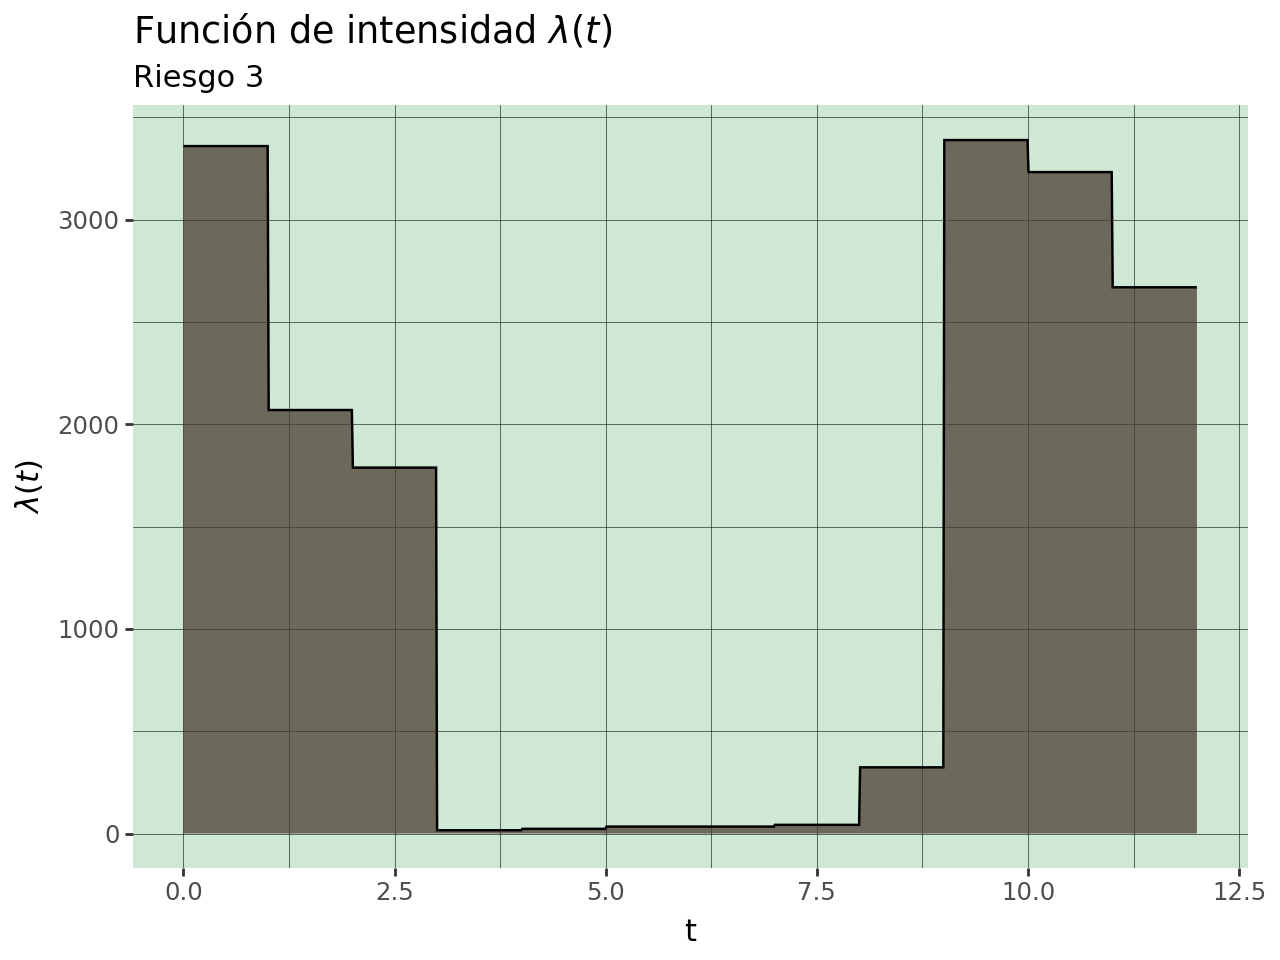

In [32]:
valoresX = np.linspace(0,12,1000)
valoresY = parametrosPoissonVectorizada(valoresX)

(ggplot()+
 geom_area(mapping=aes(x=valoresX, y=valoresY), color='black', fill='#4B3D33', alpha=0.75, size=0.5) +
 labs(title="Función de intensidad $\lambda(t)$", subtitle='Riesgo 3', x="t", y="$\lambda(t)$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

In [33]:
# Funcion Lambda para el proceso poisson no homogeneo

def parametrosPoissonAcumulados(mes):
  mediaMes1 = valoresLambda['mediaOcurrencias'][0]
  mediaMes2 = valoresLambda['mediaOcurrencias'][1]
  mediaMes3 = valoresLambda['mediaOcurrencias'][2]
  mediaMes4 = valoresLambda['mediaOcurrencias'][3]
  mediaMes5 = valoresLambda['mediaOcurrencias'][4]
  mediaMes6 = valoresLambda['mediaOcurrencias'][5]
  mediaMes7 = valoresLambda['mediaOcurrencias'][6]
  mediaMes8 = valoresLambda['mediaOcurrencias'][7]
  mediaMes9 = valoresLambda['mediaOcurrencias'][8]
  mediaMes10 = valoresLambda['mediaOcurrencias'][9]
  mediaMes11 = valoresLambda['mediaOcurrencias'][10]
  mediaMes12 = valoresLambda['mediaOcurrencias'][11]
  if mes <= 1:
    return mediaMes1
  elif mes <= 2:
    return mediaMes1 + mediaMes2
  elif mes <= 3:
    return mediaMes1 + mediaMes2 + mediaMes3
  elif mes <= 4:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4
  elif mes <= 5:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5
  elif mes <= 6:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6
  elif mes <= 7:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7
  elif mes <= 8:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8
  elif mes <= 9:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9
  elif mes <= 10:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9 + mediaMes10
  elif mes <= 11:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9 + mediaMes10 + mediaMes11
  elif mes <= 12:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9 + mediaMes10 + mediaMes11 + mediaMes12


parametrosPoissonAcumuladosVectorizada = np.vectorize(parametrosPoissonAcumulados)

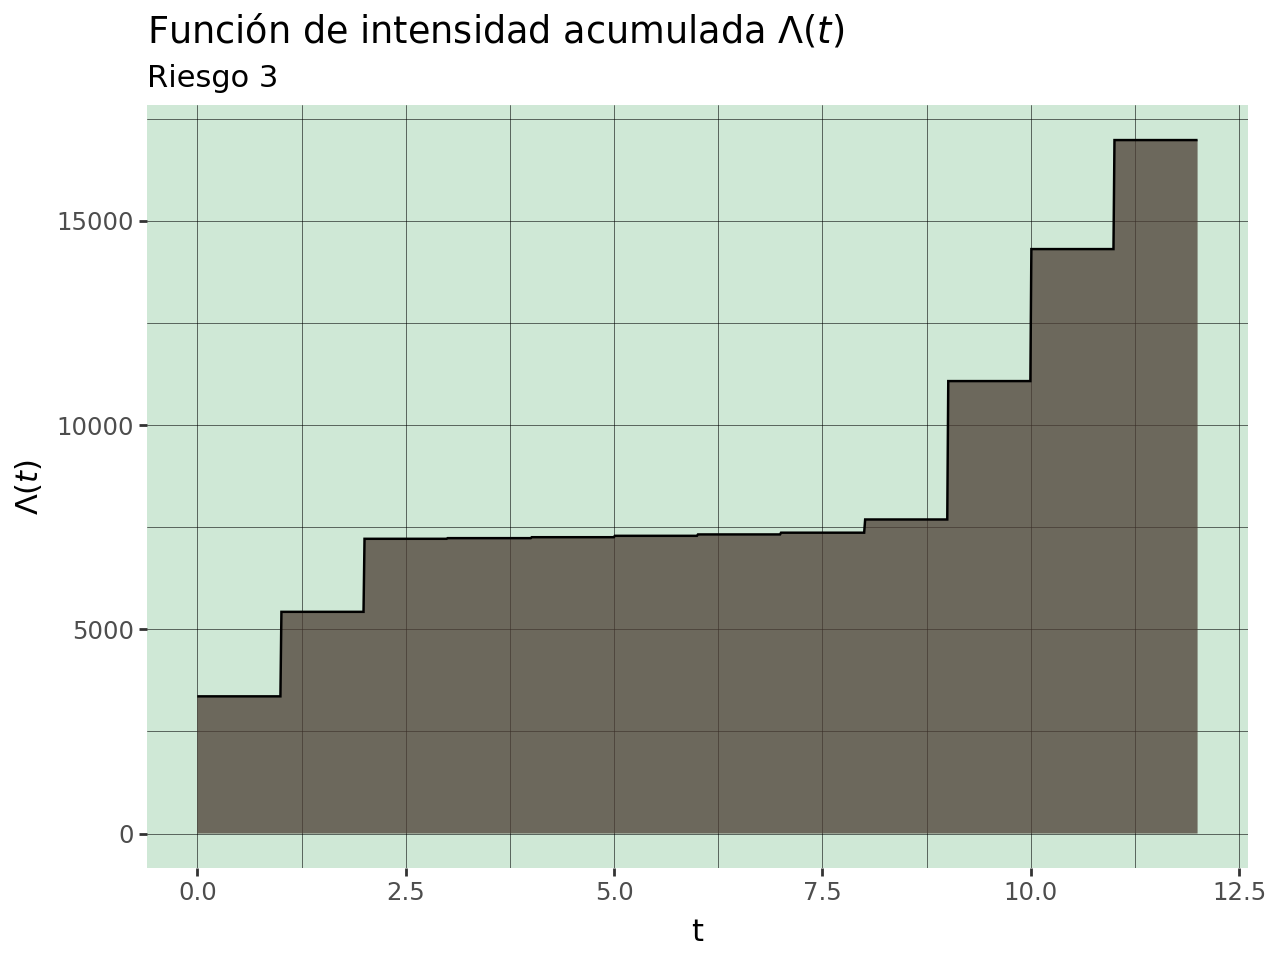

In [34]:
valoresXacumulados = np.linspace(0,12,1000)
valoresYacumulados = parametrosPoissonAcumuladosVectorizada(valoresX)

(ggplot()+
 geom_area(mapping=aes(x=valoresXacumulados, y=valoresYacumulados), color='black', fill='#4B3D33', alpha=0.75, size=0.5) +
 labs(title="Función de intensidad acumulada $\Lambda(t)$", subtitle='Riesgo 3', x="t", y="$\Lambda(t)$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
)

### Simular el proceso Poisson no homogeneo
$ X_t \sim Poisson(\Lambda (t)) $

Método de tasas acotadas
*   Simula un proceso $Poisson(\lambda^*)$
*   Para cada observación simula  $U_i(t)∼U[0,1]$
*   Si  $U_i ≤ \frac{λ(t)}{λ^*}$  acepto, si no, rechazo

En este caso $\lambda(t)$ es una función a trozos definida por\
$\lambda:[0,12] \longrightarrow [0, \infty]$

$ \lambda(t) =
\begin{cases}
\text{3359.50} & \text{si } t \leq 1 \\
\text{2069.66} & \text{si } 1 < t \leq 2 \\
\text{1788.33} & \text{si } 2 < t \leq 3 \\
\text{16.00} & \text{si } 3 < t \leq 4 \\
\text{23.00} & \text{si } 4 < t \leq 5 \\
\text{34.00} & \text{si } 5 < t \leq 6 \\
\text{34.00} & \text{si } 6 < t \leq 7 \\
\text{42.50} & \text{si } 7 < t \leq 8 \\
\text{323.50} & \text{si } 8 < t \leq 9 \\
\text{3389.00} & \text{si } 9 < t \leq 10 \\
\text{3232.50} & \text{si } 10 < t \leq 11 \\
\text{2669.50} & \text{si } 11 < t \leq 12
\end{cases} $

Acotaremos $\lambda(t)$ con $\lambda^*=max\{ \lambda(t) \} = 3389$

Primero construimos una función para generar un proceso Poisson homogeneo de tasa $\lambda$, utilizaremos estadísticos de orden.
1. Generamos $ n=Poisson(\lambda t) $
2. Genearmos $ (U_1,...,Un) \sim U(0,1) $ independientes en $[0,t]$
3. Obtenemos $ (U_{(1)},...U_{(n)}) $
4. Observación: Si $n=0$ devuelvo un vector vacío

In [35]:
# Hacemos la funcion para el proceso poisson homogeneo
def procesoPoissonHom(l,T):
  n = np.random.poisson(l*T)
  if n != 0:
    vectorUniformes = np.random.uniform(low=0, high=T, size=n)
    t = np.sort(vectorUniformes)
    Xt = np.arange(1,len(t)+1)
  # Hacemos que el proceso inicie en el tiempo cero con cero conteos
  else:
    t = [0]
    Xt = [0]
  return t, Xt

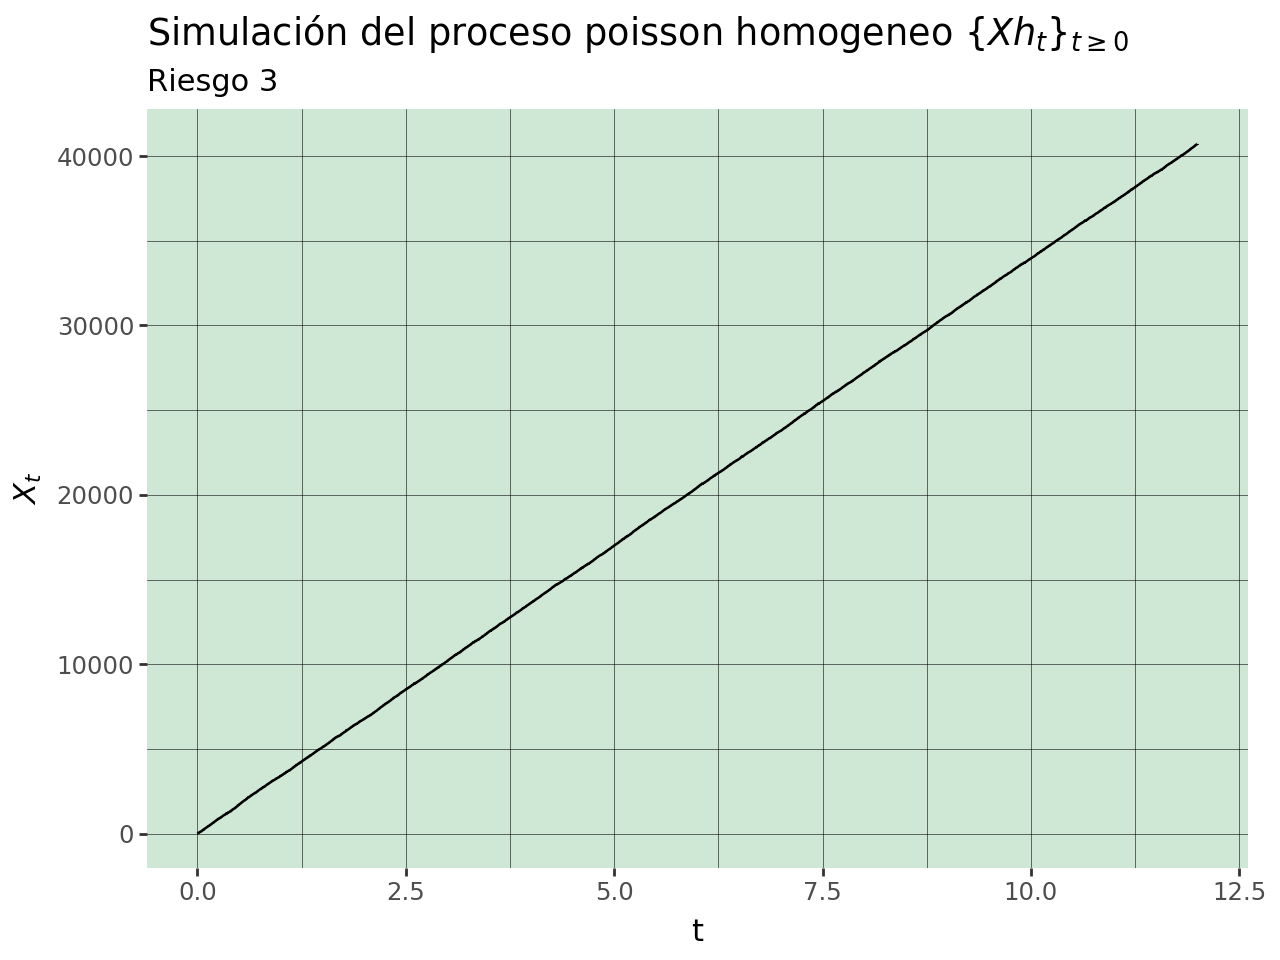

In [36]:
# Llamamos al proceso poisson homogeneo
lambdaEstrella = valoresLambda['mediaOcurrencias'].max() # Encontramos el valor de lambda estrella
np.random.seed(2024)
t, Xt = procesoPoissonHom(lambdaEstrella, 12)

# Funcion Lambda(t)
x = np.linspace(0,12)
y = lambdaEstrella*x

(ggplot() +
 #geom_point(mapping=aes(x=t, y=Xt), color="red") +
 geom_step(mapping=aes(x=t, y=Xt)) +
 #geom_line(mapping=aes(x=x,y=y)) +
 labs(title='Simulación del proceso poisson homogeneo $\{Xh_t\}_{t \geq 0}$', subtitle='Riesgo 3', x="t", y="$X_t$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

Simulamos el proceso Poisson no homogeneo

In [37]:
# Funcion que simula el proceso poisson no homogeneo

def procesoPoissonNoHom(T):
  valoresX = np.linspace(0,T)
  poisHom, Xt = procesoPoissonHom(lambdaEstrella, T)
  t = []
  for poisson in poisHom:
    u = np.random.uniform()
    if u <= (parametrosPoissonVectorizada(poisson) / parametrosPoissonVectorizada(T)):
      t.append(poisson)
  Xt = np.arange(1, len(t)+1)
  return t, Xt

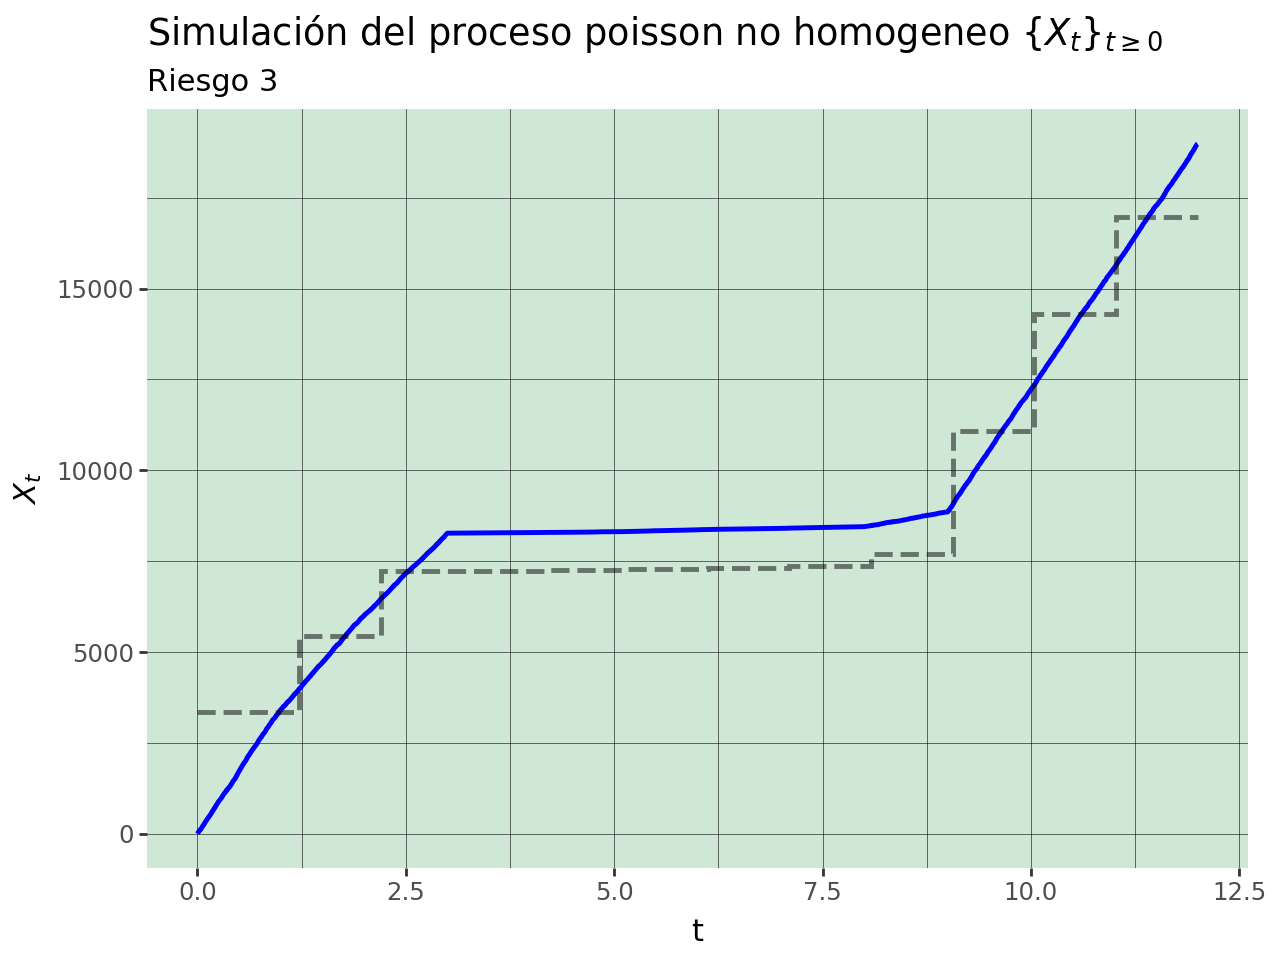

In [38]:
# Llamar a la funcion que simula el proceso poisson no homogeneo
np.random.seed(2024)
t, Xt = procesoPoissonNoHom(12)

# Trayectoria del proceso poisson no homogeneo
x = np.linspace(0,12)
y = parametrosPoissonAcumuladosVectorizada(x)

(ggplot() +
 geom_line(mapping=aes(x=t, y=Xt), color='blue', size=1) +
 geom_step(mapping=aes(x=x, y=y), linetype='dashed', size=1, alpha=0.5) +
 labs(title="Simulación del proceso poisson no homogeneo $\{X_t\}_{t \geq 0}$",
      subtitle='Riesgo 3',
      x="t", y="$X_t$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

Generamos n trayectorias simuladas del proceso Poisson no Homogéneo por el Método de Aceptación - Rechazo

In [ ]:
########### ¡¡¡¡¡¡¡¡¡ Tarda en ejecutarse !!!!!!!!!! ###########
'''
n = 1000

trayectorias = pd.DataFrame()
np.random.seed(2024)
for i in range(n):
  t, Xt = procesoPoissonNoHom(12)
  dataFrameTemporal = pd.DataFrame({"Trayectorias":t, "Conteos":Xt, "Numero de trayectoria":[i]*len(t)})
  trayectorias = pd.concat([trayectorias, dataFrameTemporal], ignore_index=True)
  '''

'\nn = 1000\n\ntrayectorias = pd.DataFrame()\nnp.random.seed(2024)\nfor i in range(n):\n  t, Xt = procesoPoissonNoHom(12)\n  dataFrameTemporal = pd.DataFrame({"Trayectorias":t, "Conteos":Xt, "Numero de trayectoria":[i]*len(t)})\n  trayectorias = pd.concat([trayectorias, dataFrameTemporal], ignore_index=True)\n  '

In [ ]:
########## ¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡ Descargar el archivo en mi computadora !!!!!!!!!!!! ##########
'''
trayectorias.to_csv('trayectoriasPPNH.csv', index=False, header=True, sep=',', encoding='utf-8')
files.download('trayectoriasPPNH.csv')
'''

"\ntrayectorias.to_csv('trayectoriasPPNH.csv', index=False, header=True, sep=',', encoding='utf-8')\nfiles.download('trayectoriasPPNH.csv')\n"

In [39]:
# Importar trayectoriasPPNH
trayectorias = pd.read_csv("trayectoriasPPNH.csv")

Graficamos las trayectorias simuladas

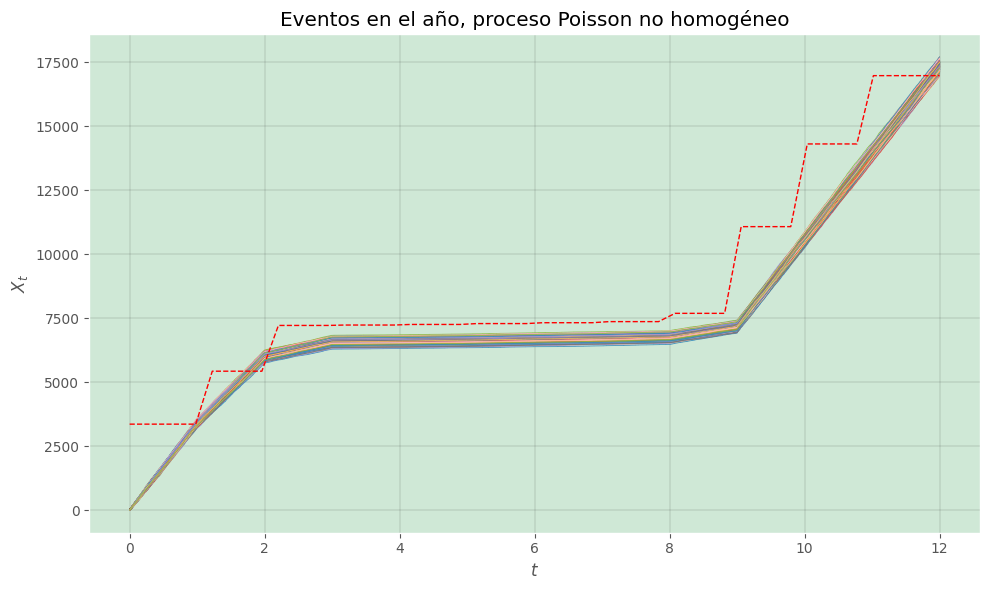

In [40]:
# Grafico de las trayectorias simuladas

# Funcion Lambda(x) = integral(lambda(t))
x = np.linspace(0,12)
y = parametrosPoissonAcumuladosVectorizada(x)

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

# Grafico de escalera para cada simulacion
for num_trayectoria in trayectorias['Numero de trayectoria'].unique():
    # Datos de la trayectoria actual
    df_trayectoria = trayectorias[trayectorias['Numero de trayectoria'] == num_trayectoria]

    # Grafico de escalera para la trayectoria actual
    plt.step(df_trayectoria['Trayectorias'], df_trayectoria['Conteos'], where='post', alpha=0.9, linewidth=0.6)

# Graficar funcion Lambda(x) = integral(lambda(t))
plt.plot(x, y, color='red', linestyle='--', linewidth=1, label='Lambda(x)')

plt.gca().set_facecolor("#cfe8d6") # Fondo
plt.grid(color='black', linewidth=0.1) #Cuadricula
plt.xlabel('$t$')
plt.ylabel('$X_t$')
plt.title('Eventos en el año, proceso Poisson no homogéneo')
plt.tight_layout()
plt.show()

,Numero de trayectoria,TotalEventos
0,0,17267
1,1,17497
2,2,17422
3,3,17533
4,4,17366
...,...,...
995,995,17262
996,996,17351
997,997,17480
998,998,17506


/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 22'. Pick better value with 'binwidth'.


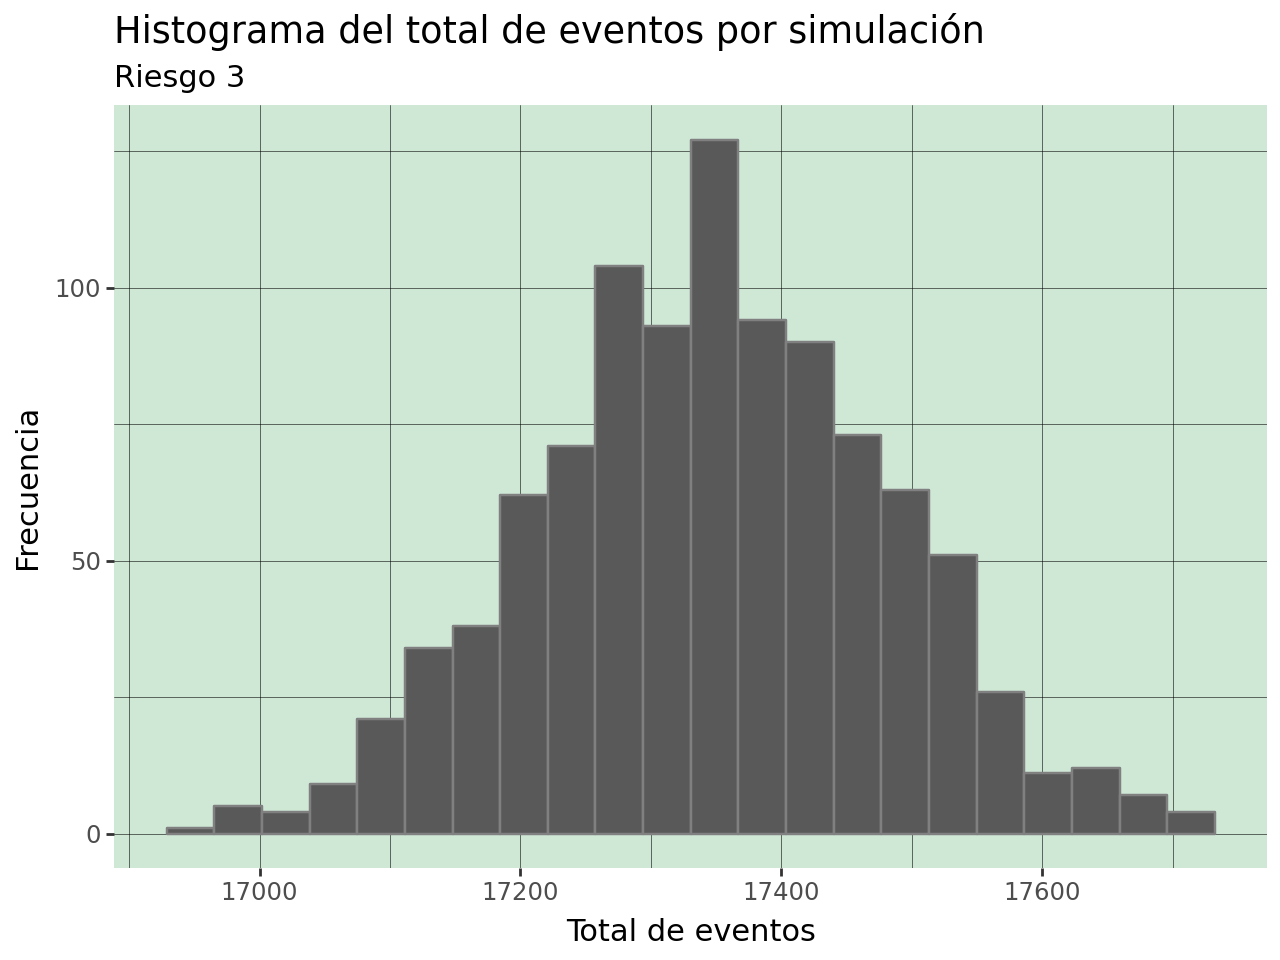

In [41]:
# Obtenemos el numero total de eventos en cada simulacion
NoEventos = (trayectorias >> group_by('Numero de trayectoria') >> summarize(TotalEventos = np.max(_.Conteos)))

display(NoEventos)

# Vemos el histograma de eventros por simulacion
display(ggplot() +
        geom_histogram(mapping=aes(x=NoEventos["TotalEventos"]), color='grey') +
        labs(title="Histograma del total de eventos por simulación",
              subtitle='Riesgo 3',
              x="Total de eventos", y="Frecuencia") +
        theme(panel_background=element_rect(fill="#cfe8d6", color=None),
              panel_grid=element_line(color="black", size=0.2)
              )
        )

### Simular el proceso poisson compuesto no homogeneo
$ Y_t = \displaystyle\sum_{i=1}^{N_t} X_i $\
$\{N_t\} _{t \geq 0}$ es un proceso poisson no homogeneo\
$\{X_i\}_{i=1}^n$ es un conjunto de variables aleatorias independientes e idénticamente distribuidas, que además son independientes de las variables $\{N_t\} _{t \geq 0}$

La esperanza de $Y_t$ es\
$ \mathbb{E}(Y_t) = \mathbb{E}(\mathbb{E}(Y_t|N_t)) = \mathbb{E}(N_t)\mathbb{E}(X) $

La varianza de $Y_t$ es\
$ Var(Y_t) = \mathbb{E}(Var(Y_t|N_t)) + Var(\mathbb{E}(Y_t|N_t))= $\
$ \mathbb{E}(N_tVar(X)) + Var(N_t\mathbb{E}(X)) = $\
$ Var(X) \mathbb{E}(N_t) + \mathbb{E}(X)^2 Var(N_t) $

$ \mathbb{E}(N_t) = \displaystyle\int_0^t \lambda(x) dx = \Lambda(t) $\
$ \mathbb{E}(N_{12}) = \mathbb{E}[N(12) - N(0)] = \displaystyle\int_0^{12} \lambda(x) dx = 16981.5 $\
Además $ Var(N_t) = \mathbb{E}(N_t)$

Usaremos como estimadores\
$$\widehat{\mathbb{E}(X)} = \overline{X} = \frac{1}{n}\displaystyle\sum_{i=1}^n X_i, ~~~ \widehat{Var(X)} = \frac{1}{n-1}\displaystyle\sum_{i=1}^n (X_i - \overline{X})^2 $$

Por lo que
$$ \widehat{\mathbb{E}(Y_t)} = \Lambda(t)*1081694.923262261 $$
$$ \widehat{\mathbb{E}(Y_{12})} = 16981.5*1081694.923262261 = 18368802339.3780 $$

Y además
$$ \widehat{Var(Y_t)} = 233962639949.6137*\Lambda(t) + 1081694.9232^2*\Lambda(t) $$
$$ \widehat{Var(Y_{12})} = 233962639949.6137*16981.5 + 1081694.9232^2*16981.5 = 1.986945860571556e+16 $$

De donde
$$ \widehat{Std(Y_t)} = 140959067.1284 $$

In [42]:
E_Nt = valoresYacumulados.max()
Var_Nt = E_Nt
E_X = np.mean(eventos)
E_Yt = valoresYacumulados.max()*np.mean(eventos)
Var_X = np.var(eventos, ddof=1)
Var_Yt = valoresYacumulados.max()*np.mean(eventos) + (E_X)**2 * Var_Nt
sd_Yt = np.sqrt(Var_Yt)

# Calculo de la esperanza E(N(t))
print(f'Esperanza, Varianza de N_t: {E_Nt}')

# Calculo de la esperanza E(X)
print(f'Esperanza de X: {E_X}')

# Calculo de la esperanza E(Y_t)
print(f'Esperanza de Y_t: {E_Yt}')

# Calculo de la varianza Var(X)
print(f'Varianza de X: {Var_X}')

# Calculo de la varianza var(Y_t)
print(f'Varianza de Y_t: {Var_Yt}')

# Calculo de la desviacion estandar sd(Y_t)
print(f'Desviacion estandar de Y_t: {sd_Yt}')

Esperanza, Varianza de N_t: 16981.5
Esperanza de X: 1162657.7202946423
Esperanza de Y_t: 19743672077.183468
Varianza de X: 299501087019.47864
Varianza de Y_t: 2.295515251117519e+16
Desviacion estandar de Y_t: 151509578.9419771


# Obtenemos un dataframe con las severidades en cada evento

In [43]:
NoTrayectorias = trayectorias['Numero de trayectoria'].max() + 1 # Obtenemos el numero de trayectorias

SimulacionesPerdidas = pd.DataFrame() # Creamos un dataframe vacio para almacenar las trayectorias

# A cada trayectoria le agregaremos una columna con la severidad por evento y la severidad acumulada
for i in range(NoTrayectorias+1): # Sumamos 1 por el slicing
  # Filtramos por el numero de trayectoria
  Perdida = (trayectorias >> filter(_['Numero de trayectoria'] == i))
  # Agregamos una severidad a cada evento y posteriormente hacemos la suma acumulada de severidades
  Perdida = (Perdida >> mutate(Severidad = simulacionDistEmpirica(len(Perdida))) >> mutate(SeveridadAcumulada = _.Severidad.cumsum()))
  SimulacionesPerdidas = pd.concat([SimulacionesPerdidas, Perdida])

SimulacionesPerdidas

,Trayectorias,Conteos,Numero de trayectoria,Severidad,SeveridadAcumulada
0,0.000211,1,0,1.461069e+06,1.461069e+06
1,0.000402,2,0,9.714231e+05,2.432492e+06
2,0.000592,3,0,1.339064e+06,3.771556e+06
3,0.000973,4,0,7.206655e+05,4.492221e+06
4,0.001210,5,0,7.304510e+05,5.222672e+06
...,...,...,...,...,...
17346921,11.998058,17262,999,1.811253e+06,2.018512e+10
17346922,11.998379,17263,999,9.550226e+05,2.018607e+10
17346923,11.998704,17264,999,8.151342e+05,2.018689e+10
17346924,11.999390,17265,999,3.130421e+06,2.019002e+10


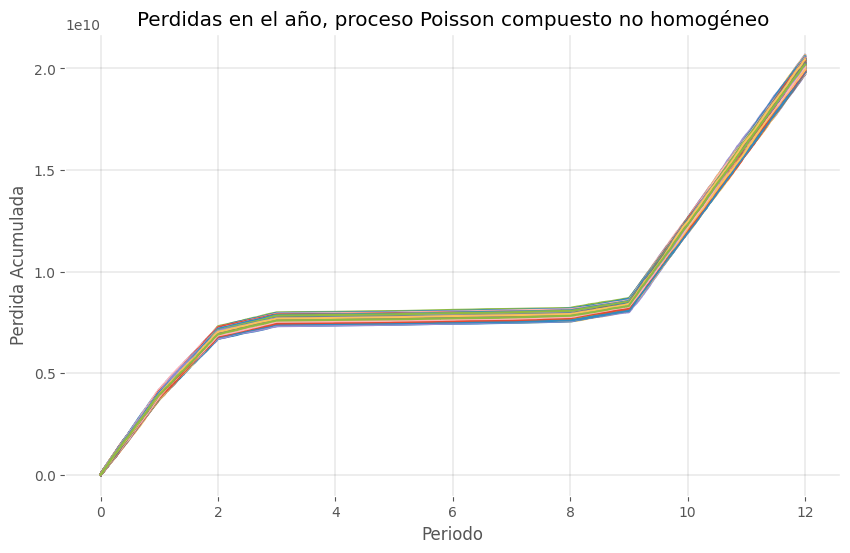

In [44]:
# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Agrupar por 'Numero de trayectoria' y hacer una gráfica de líneas para cada trayectoria
for trayectoria, datos in SimulacionesPerdidas.groupby('Numero de trayectoria'):
    plt.plot(datos['Trayectorias'], datos['SeveridadAcumulada'], label=f'Trayectoria {trayectoria}')

# Añadir etiquetas y título
plt.gca().set_facecolor("white") # Fondo
plt.grid(color='black', linewidth=0.1) #Cuadricula
plt.xlabel('Periodo')
plt.ylabel('Perdida Acumulada')
plt.title(f'Perdidas en el año, proceso Poisson compuesto no homogéneo')
plt.show()

Obtenemos la perdida total del año en cada simulación

In [45]:
perdidaFinal = (SimulacionesPerdidas >> group_by(_['Numero de trayectoria']) >> summarize(perdidaFinal = _.SeveridadAcumulada.max()))
perdidaFinal

,Numero de trayectoria,perdidaFinal
0,0,2.014987e+10
1,1,2.028924e+10
2,2,2.012437e+10
3,3,2.045330e+10
4,4,2.012979e+10
...,...,...
995,995,2.024784e+10
996,996,2.016655e+10
997,997,2.029237e+10
998,998,2.045088e+10


La media de las perdidas es: 20169241044.992313 
La desviacion estandar de las perdidas es: 168326760.53961173 


/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 21'. Pick better value with 'binwidth'.


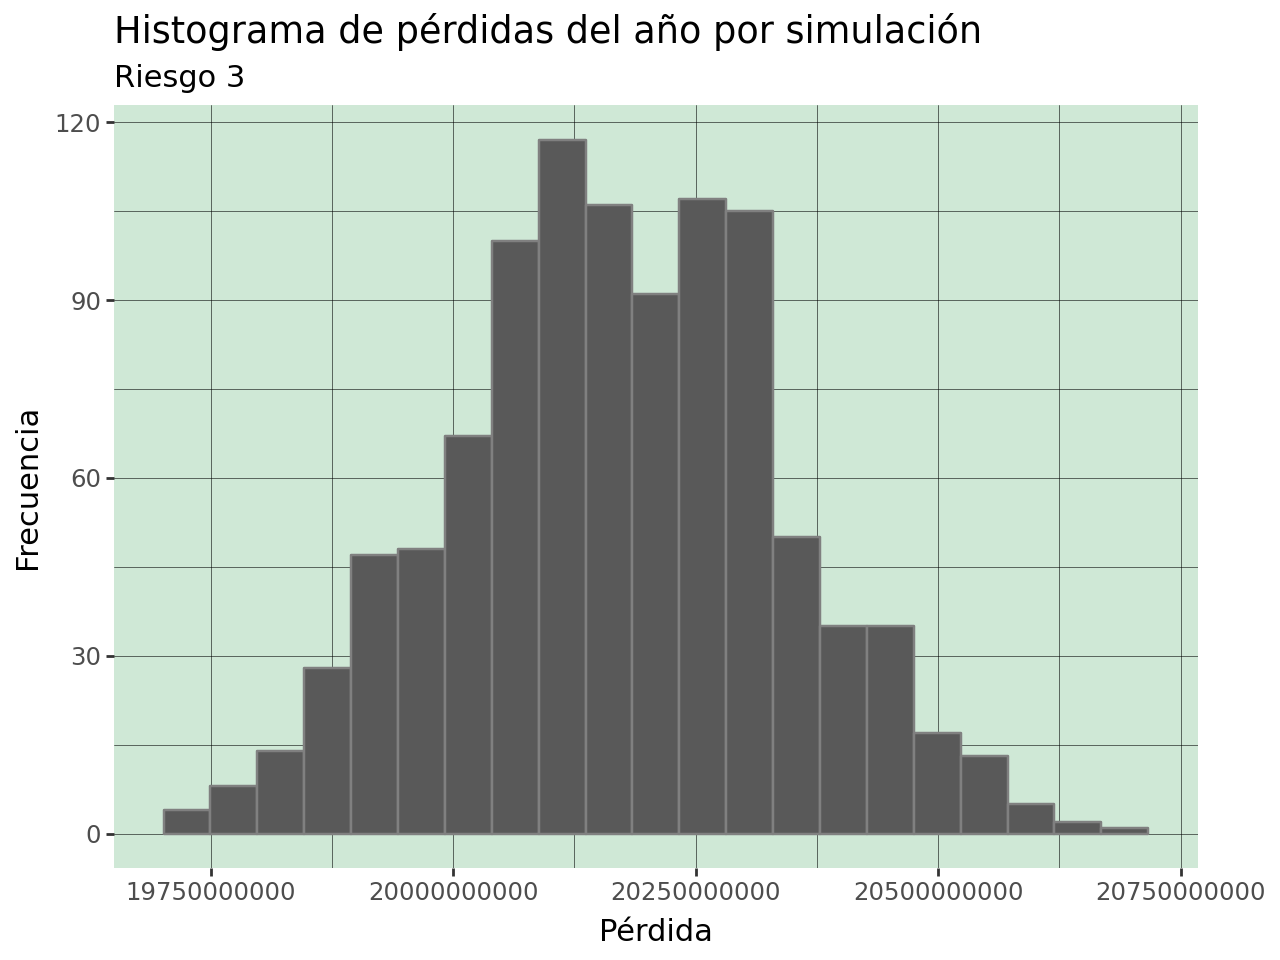

In [46]:
mediaPerdidas = np.mean(perdidaFinal['perdidaFinal'])
sdPerdidas = np.std(perdidaFinal['perdidaFinal'])
print(f'La media de las perdidas es: {mediaPerdidas} ')
print(f'La desviacion estandar de las perdidas es: {sdPerdidas} ')

(ggplot(data = perdidaFinal) +
 geom_histogram(mapping=aes(x='perdidaFinal'), color='grey') +
 labs(title="Histograma de pérdidas del año por simulación",
      subtitle='Riesgo 3',
      x="Pérdida", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

In [47]:
# Calculo del VaR

perdidas = perdidaFinal['perdidaFinal']

VaR95 = np.percentile(perdidas, 95)
VaR99 = np.percentile(perdidas, 99)

display(VaR95)
display(VaR99)

20450878141.960884

20554913071.46951

In [48]:
# Calculo del TVaR

cola95 = perdidas[perdidas>VaR95]
TVaR95 = np.mean(cola95)

cola99 = perdidas[perdidas>VaR99]
TVaR99 = np.mean(cola99)

display(TVaR95)
display(TVaR99)

20516671910.37621

20603768799.57947

# Tomamos los valores a fin de mes

In [58]:
'''
SimulacionesPerdidas
'''

,Trayectorias,Conteos,Numero de trayectoria,Severidad,SeveridadAcumulada
0,0.000211,1,0,1.461069e+06,1.461069e+06
1,0.000402,2,0,9.714231e+05,2.432492e+06
2,0.000592,3,0,1.339064e+06,3.771556e+06
3,0.000973,4,0,7.206655e+05,4.492221e+06
4,0.001210,5,0,7.304510e+05,5.222672e+06
...,...,...,...,...,...
17346921,11.998058,17262,999,1.811253e+06,2.018512e+10
17346922,11.998379,17263,999,9.550226e+05,2.018607e+10
17346923,11.998704,17264,999,8.151342e+05,2.018689e+10
17346924,11.999390,17265,999,3.130421e+06,2.019002e+10


In [96]:
# Crear un DataFrame vacío
perdidasFinMes = pd.DataFrame(columns = SimulacionesPerdidas.columns)

In [97]:
for j in range(13):
  for i in range(1000):
    fila = SimulacionesPerdidas[(SimulacionesPerdidas['Numero de trayectoria'] == i) & (SimulacionesPerdidas['Trayectorias'] <= j)][-1:]
    perdidasFinMes = pd.concat([perdidasFinMes, fila], ignore_index=True)

In [101]:
perdidasFinMes

,Trayectorias,Conteos,Numero de trayectoria,Severidad,SeveridadAcumulada
0,0.999654,3412,0,1.404221e+06,4.021757e+09
1,0.999913,3446,1,9.172696e+05,4.011162e+09
2,0.999795,3369,2,8.219024e+05,3.851366e+09
3,0.999858,3393,3,4.954094e+05,3.948886e+09
4,0.999999,3393,4,1.456797e+06,3.955832e+09
...,...,...,...,...,...
11995,11.999445,17262,995,9.282723e+05,2.024784e+10
11996,11.999897,17351,996,8.433070e+05,2.016655e+10
11997,11.999906,17480,997,1.354983e+06,2.029237e+10
11998,11.999970,17506,998,2.013894e+06,2.045088e+10


In [102]:
dfAnexo = pd.DataFrame({
    'Trayectorias': [0] * 1000,
    'Conteos': [0] * 1000,
    'Numero de trayectoria': list(range(1000)),
    'Severidad': [0] * 1000,
    'SeveridadAcumulada': [0] * 1000
})

In [107]:
perdidasFinMes = pd.concat([dfAnexo, perdidasFinMes], ignore_index=True)
perdidasFinMes

,Trayectorias,Conteos,Numero de trayectoria,Severidad,SeveridadAcumulada
0,0.000000,0,0,0.000000e+00,0.000000e+00
1,0.000000,0,1,0.000000e+00,0.000000e+00
2,0.000000,0,2,0.000000e+00,0.000000e+00
3,0.000000,0,3,0.000000e+00,0.000000e+00
4,0.000000,0,4,0.000000e+00,0.000000e+00
...,...,...,...,...,...
13995,11.999445,17262,995,9.282723e+05,2.024784e+10
13996,11.999897,17351,996,8.433070e+05,2.016655e+10
13997,11.999906,17480,997,1.354983e+06,2.029237e+10
13998,11.999970,17506,998,2.013894e+06,2.045088e+10


In [108]:
perdidasFinMes.to_csv('perdidasFinMes.csv', index=False)

Podemos obtener las perdidas en un periodo $[a,b]$

In [49]:
a = 3
b = 8

SimulacionesAcotadas = (SimulacionesPerdidas >>
                        select(-_.SeveridadAcumulada) >> # Quitamos las severidades acumuladas
                        filter((_.Trayectorias > a) & (_.Trayectorias < b))) # Tomamos solo los eventos que ocurrieron en el periodo [a,b]

### Añadimos la nueva severidad acumulada ###

NoTrayectorias = SimulacionesAcotadas['Numero de trayectoria'].max() + 1 # Obtenemos el numero de trayectorias

SimulacionesPerdidasAcotadas = pd.DataFrame() # Creamos un dataframe vacio para almacenar las trayectorias

# A cada trayectoria le agregaremos una columna con la severidad por evento y la severidad acumulada
for i in range(NoTrayectorias+1): # Sumamos 1 por el slicing
  # Filtramos por el numero de trayectoria
  Perdida = (SimulacionesAcotadas >> filter(_['Numero de trayectoria'] == i))
  # Agregamos una severidad a cada evento y posteriormente hacemos la suma acumulada de severidades
  Perdida = (Perdida >> mutate(Severidad = simulacionDistEmpirica(len(Perdida))) >> mutate(SeveridadAcumulada = _.Severidad.cumsum()))
  SimulacionesPerdidasAcotadas = pd.concat([SimulacionesPerdidasAcotadas, Perdida])

SimulacionesPerdidasAcotadas

,Trayectorias,Conteos,Numero de trayectoria,Severidad,SeveridadAcumulada
6557,3.052901,6558,0,2.580273e+06,2.580273e+06
6558,3.054159,6559,0,1.734468e+06,4.314741e+06
6559,3.120028,6560,0,1.117352e+06,5.432093e+06
6560,3.175069,6561,0,1.048274e+06,6.480367e+06
6561,3.306193,6562,0,1.068156e+06,7.548523e+06
...,...,...,...,...,...
17336321,7.827213,6662,999,7.674918e+05,2.240294e+08
17336322,7.864771,6663,999,7.799793e+05,2.248094e+08
17336323,7.941484,6664,999,1.518766e+06,2.263282e+08
17336324,7.959201,6665,999,1.441494e+06,2.277697e+08


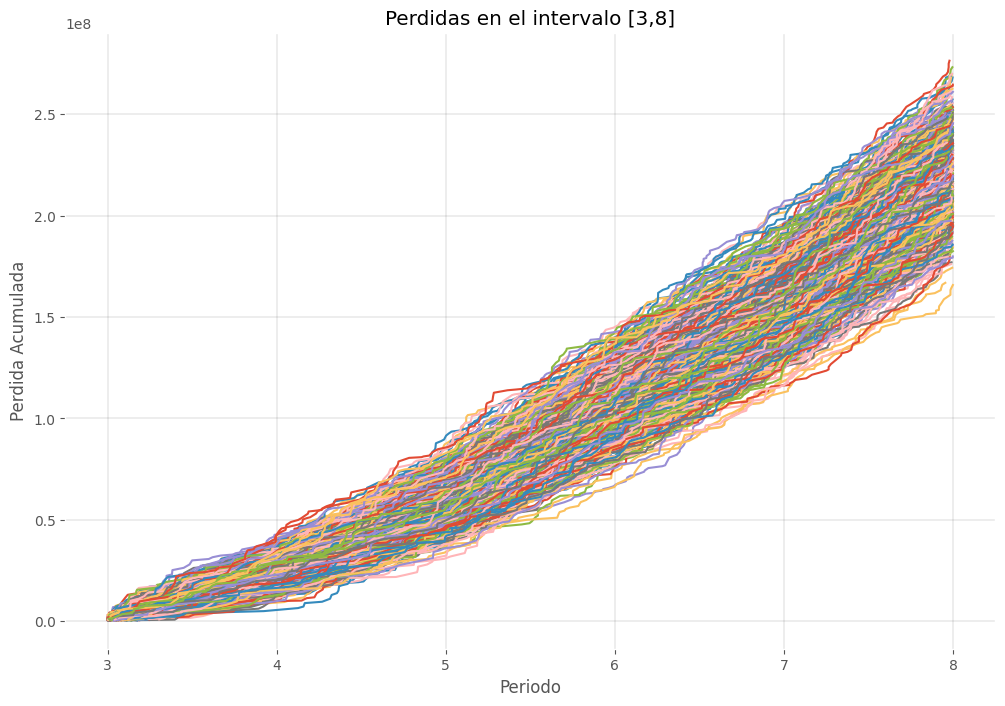

In [50]:
# Volvemos a graficar
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

# Agrupar por 'Numero de trayectoria' y hacer un gráfico de líneas para cada trayectoria
for trayectoria, datos in SimulacionesPerdidasAcotadas.groupby('Numero de trayectoria'):
    plt.plot(datos['Trayectorias'], datos['SeveridadAcumulada'], label=f'Trayectoria {trayectoria}')

# Añadir etiquetas y título
plt.gca().set_facecolor("white") # Fondo
plt.grid(color='black', linewidth=0.1) #Cuadricula
plt.xlabel('Periodo')
plt.ylabel('Perdida Acumulada')
plt.title(f'Perdidas en el intervalo [{a},{b}]')
plt.show()

Obteneos la perdida final del periodo

In [51]:
perdidaFinalAcotada = (SimulacionesPerdidasAcotadas >> group_by(_['Numero de trayectoria']) >> summarize(perdidaFinal = _.SeveridadAcumulada.max()))
perdidaFinalAcotada

,Numero de trayectoria,perdidaFinal
0,0,2.011313e+08
1,1,2.255750e+08
2,2,2.065616e+08
3,3,2.048783e+08
4,4,2.113435e+08
...,...,...
995,995,2.113879e+08
996,996,1.974862e+08
997,997,2.123525e+08
998,998,2.424918e+08


La media de las perdidas es: 220133218.47312364 
La desviacion estandar de las perdidas es: 17832384.01331473 


/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 23'. Pick better value with 'binwidth'.


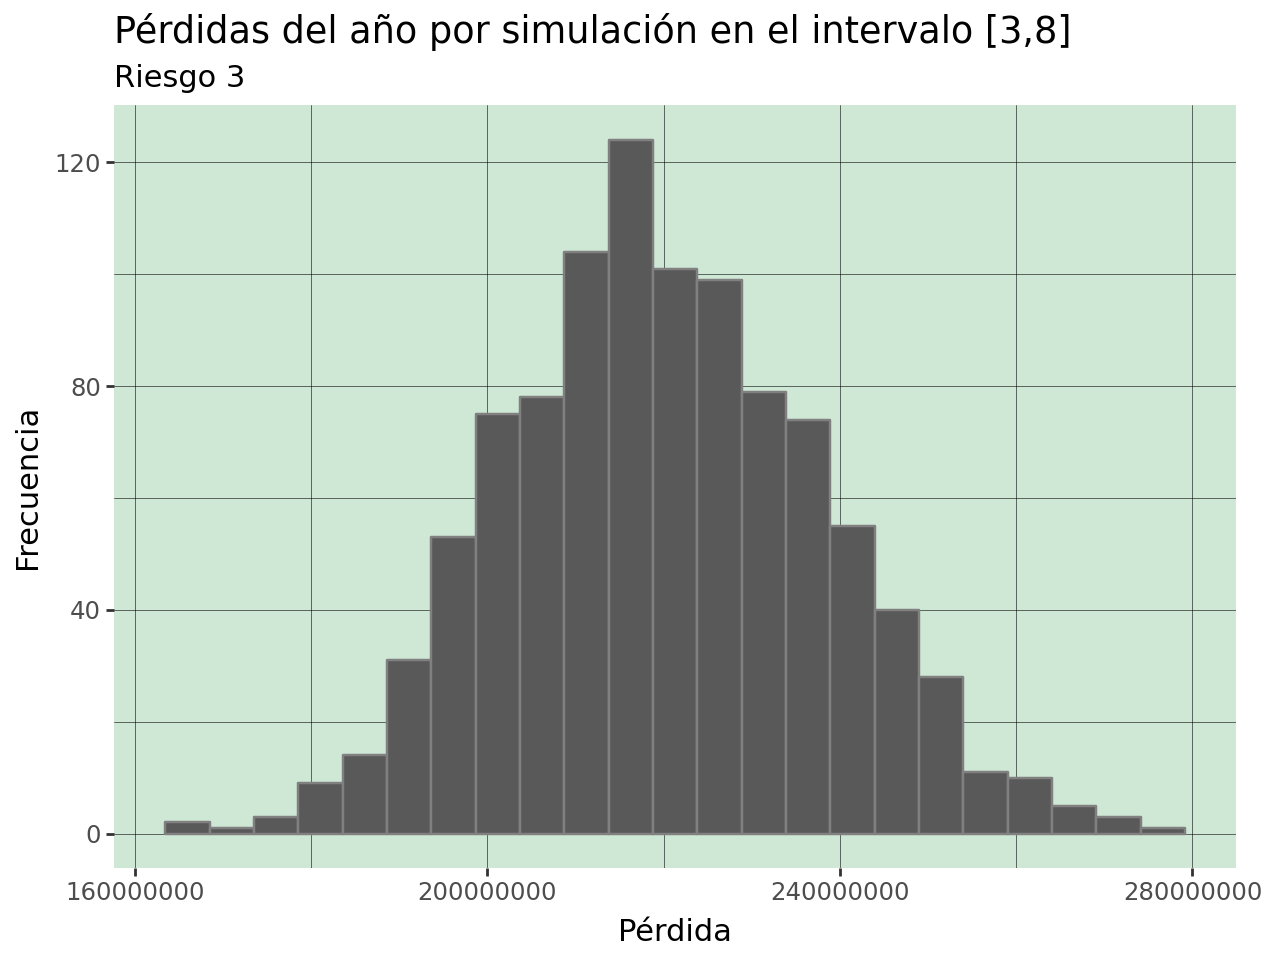

In [52]:
mediaPerdidasAcotadas = np.mean(perdidaFinalAcotada['perdidaFinal'])
sdPerdidasAcotadas = np.std(perdidaFinalAcotada['perdidaFinal'])
print(f'La media de las perdidas es: {mediaPerdidasAcotadas} ')
print(f'La desviacion estandar de las perdidas es: {sdPerdidasAcotadas} ')

(ggplot(data = perdidaFinalAcotada) +
 geom_histogram(mapping=aes(x='perdidaFinal'), color='grey')+
 labs(title=f"Pérdidas del año por simulación en el intervalo [{a},{b}]",
      subtitle='Riesgo 3',
      x="Pérdida", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

## Ajuste de distribución
Ajustaremos una curva normal a la distribución de pérdidas

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 21'. Pick better value with 'binwidth'.


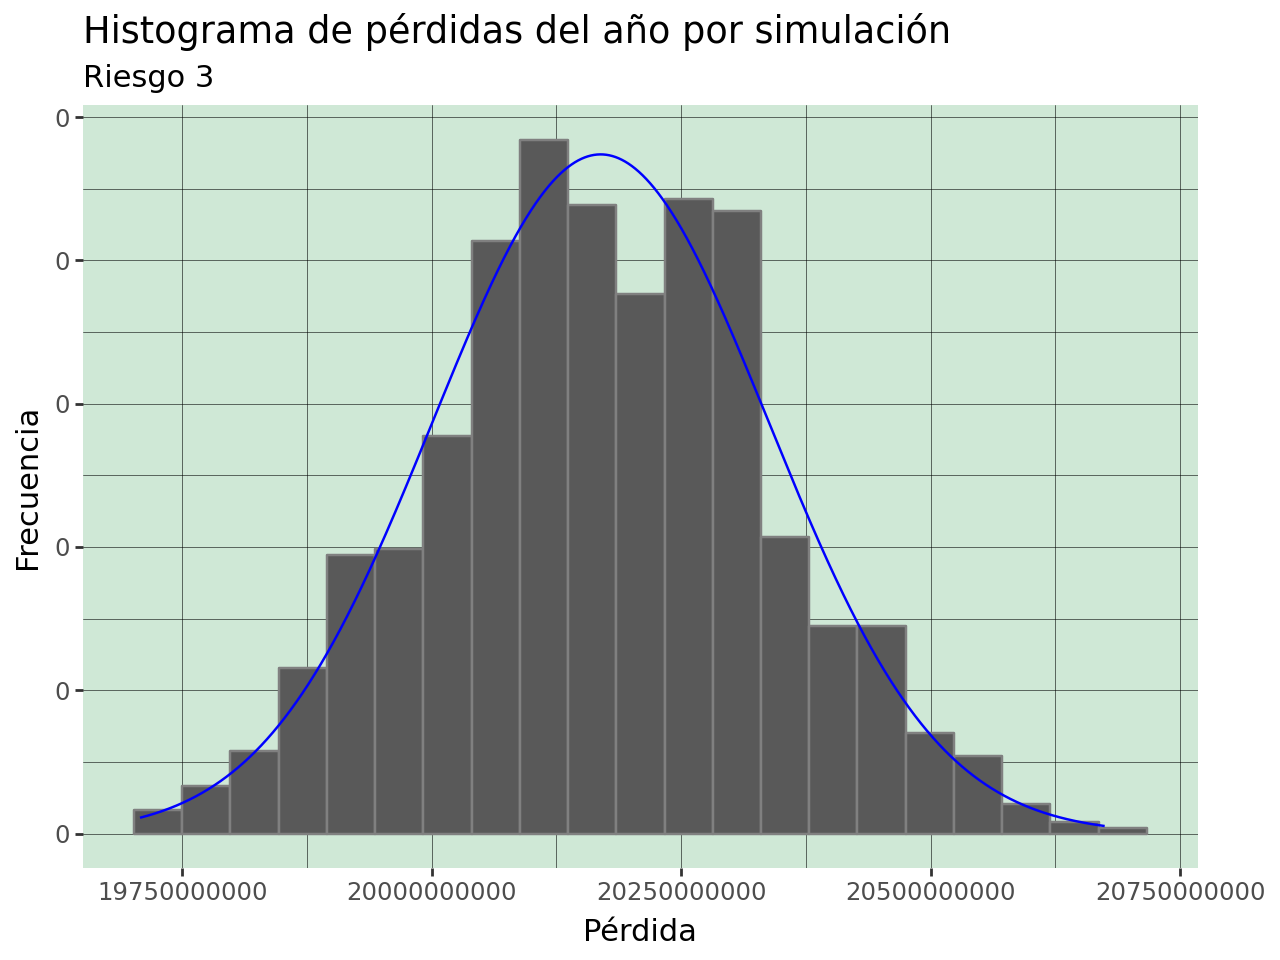

In [53]:
min = np.min(perdidaFinal['perdidaFinal'])
max = np.max(perdidaFinal['perdidaFinal'])
mediaPerdidas = np.mean(perdidaFinal['perdidaFinal'])
sdPerdidas = np.std(perdidaFinal['perdidaFinal'])

ejeX = np.linspace(min, max, 10000)
ejeY = norm.pdf(ejeX, loc=mediaPerdidas, scale=sdPerdidas)


(ggplot() +
 geom_histogram(data = perdidaFinal, mapping=aes(x='perdidaFinal', y='..density..'), color='grey') +
 geom_line(mapping=aes(x=ejeX, y=ejeY), color='blue') +
 labs(title="Histograma de pérdidas del año por simulación",
      subtitle='Riesgo 3',
      x="Pérdida", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

## Prueba de bondad de ajuste Shapiro-Willks

In [54]:
stat, p_value = stats.shapiro(perdidaFinal['perdidaFinal'])

if p_value > 0.05:
    print(f"p-valor = {p_value}, los datos siguen una distribución normal (no se rechaza H0)")
else:
    print(f"p-valor = {p_value}, los datos no siguen una distribución normal (se rechaza H0)")

p-valor = 0.34962107166858747, los datos siguen una distribución normal (no se rechaza H0)


## Q-Q plot

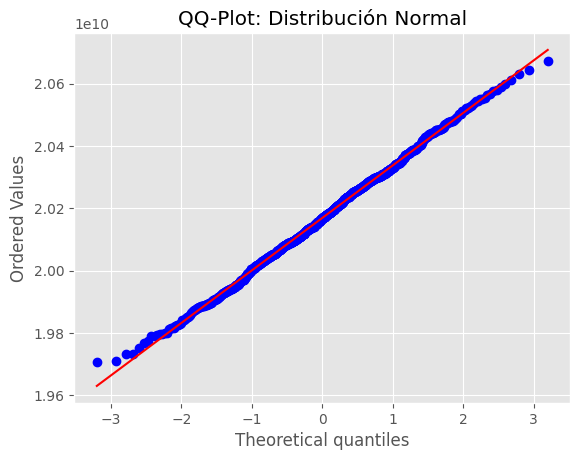

In [55]:
normales = np.random.normal(loc=0, scale=1, size=1000)

# Generar el QQ-plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Realizar el QQ-plot comparando los cuantiles de la normal
stats.probplot(perdidaFinal['perdidaFinal'], dist="norm", plot=ax)

# Mostrar el gráfico
plt.title('QQ-Plot: Distribución Normal')
plt.show()

# Cálculo del VaR y TVaR

In [56]:
# VaR
var = np.quantile(perdidaFinal['perdidaFinal'], 0.95)
var

20450878141.960884

In [57]:
# TVaR
np.mean((perdidaFinal >> filter(_.perdidaFinal > 20450878141.960884))['perdidaFinal'])

20516671910.37621

Teorema de atracción de dominio maximal

Ajustando una Gumbel a las pérdidas por año\
La distribución Gumbel tiene la siguiente función de densidad
$$ f(t; \mu,\lambda ) = \frac{1}{\lambda} exp \left( -\frac{t-\mu}{\lambda}\right) exp \left( -exp \left( -\frac{t-\mu}{\lambda} \right) \right) $$
Entonces
$$ F(t;\mu, \lambda) = exp \left( -exp \left( -\frac{t-\mu}{\lambda} \right) \right) $$
Sea $ z = ln(-ln(F(t))) $\
Entonces $ z = -\frac{t-\mu}{\lambda} = \frac{\mu}{\lambda} - \frac{1}{\lambda}t $\
Tomamos el modelo $ y = \beta_0 + \beta_1 x $\
Donde $y=ln \left( -ln(F(t)) \right)$\
$ \beta_0 = \frac{\mu}{\lambda}$\
$ \beta_1 = -\frac{1}{\lambda} $\
$ x=t $

Primero obtenemos la función de supervivencia $S(t)$ empírica\
Después obtenemos $F(t)$\
Posteriormente calculamos $y=ln(-ln(F(t)))$

,Numero de trayectoria,perdidaFinal,i,St,Ft,y,const
585,585,1.975309e+10,996,0.996,4.000000e-03,1.708642,1
818,818,1.973307e+10,997,0.997,3.000000e-03,1.759433,1
143,143,1.973258e+10,998,0.998,2.000000e-03,1.826903,1
450,450,1.970837e+10,999,0.999,1.000000e-03,1.932645,1
745,745,1.970754e+10,1000,1.000,1.110223e-16,3.603779,1


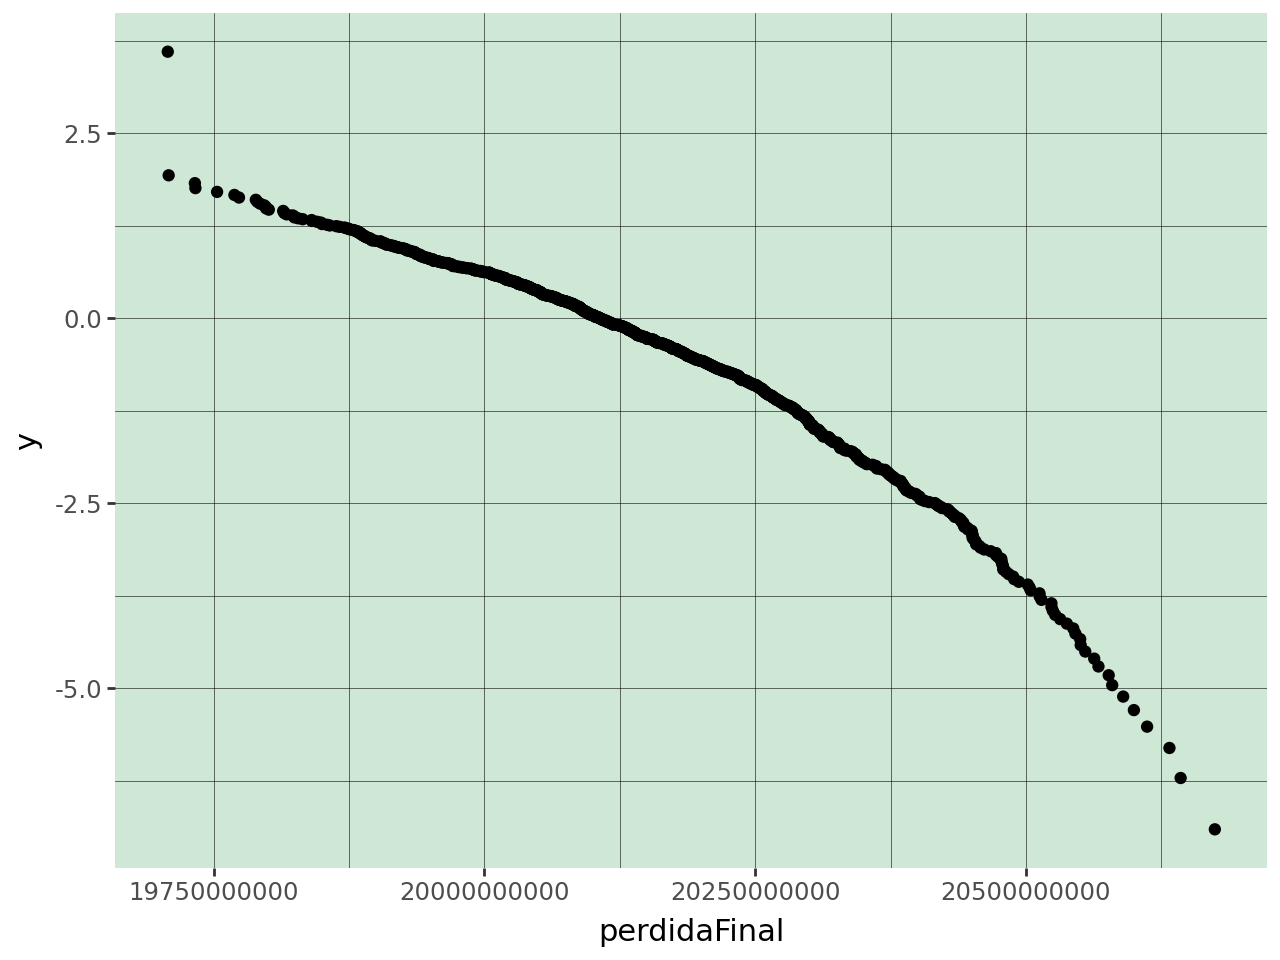

In [58]:
# Construimos la funcion de distribucion acumulada

n=perdidaFinal.shape[0]

regresionLineal = (perdidaFinal >>
                   arrange(-_.perdidaFinal) >>
                   mutate(i=range(1, n+1),
                          St=_.i/(n+0.0000000000001), # sumamos 1*10^{-13} porque en la perdida mas grande Ft da infinito
                          Ft = 1-_.St,
                          y = np.log(-np.log(_.Ft)),
                          const = 1,)
                   )

display(regresionLineal.tail())

(ggplot(regresionLineal) +
 geom_point(aes(x='perdidaFinal', y='y')) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

In [59]:
# Hacemos la regresión lineal

predictors = ["const", "perdidaFinal"]
target = "y"
fit = sm.OLS(regresionLineal[target], regresionLineal[predictors]).fit()
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.784e+04
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        04:04:39   Log-Likelihood:                -192.85
No. Observations:                1000   AIC:                             389.7
Df Residuals:                     998   BIC:                             399.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          148.0678      1.113    133.032      0.000     145.884     150.252
perdidaFinal  -7.37e-09   5.52e-11   -133.549      0.000   -7.48e-09   -7.26e-09
==============================================================================
Omnibus:                      657.113   Durbin-Watson:                   0.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9170.429
Skew:                          -2.834   Prob(JB):                         0.00
Kurtosis:                      16.710   Cond. No.                     2.42e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
betas = fit.params
lambGumbel = -1/betas[1]
muGumbel = -betas[0]/betas[1]

print(f"lambda={lambGumbel}\nmu={muGumbel}")

lambda=135693615.53752697
mu=20091852018.962833


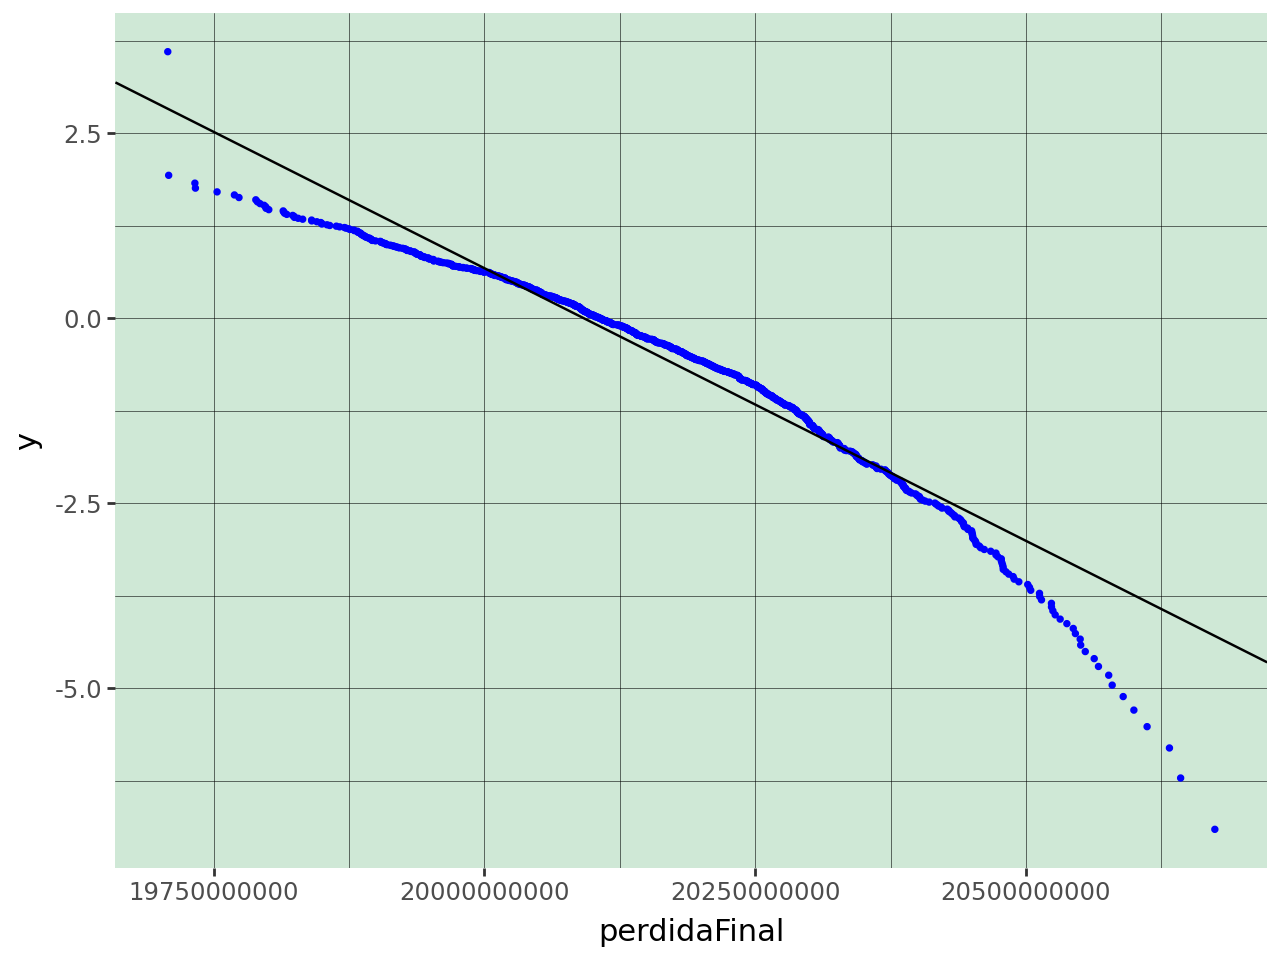

In [61]:
(ggplot(regresionLineal) +
 geom_point(mapping=aes(x='perdidaFinal', y='y'), color='blue', size=0.5) +
 geom_abline(intercept=betas[0], slope=betas[1]) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

In [62]:
minPerdida = perdidaFinal['perdidaFinal'].min()
maxPerdida = perdidaFinal['perdidaFinal'].max()
n = 10000

intervaloPerdida = np.linspace(min, max, n)
densidadGumbel = gumbel_r.pdf(intervaloPerdida, loc=muGumbel, scale=lambGumbel)

In [63]:
densidadGumbel

array([5.27342421e-15, 5.33380917e-15, 5.39483909e-15, ...,
       9.93959241e-11, 9.93260810e-11, 9.92562862e-11])

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 21'. Pick better value with 'binwidth'.


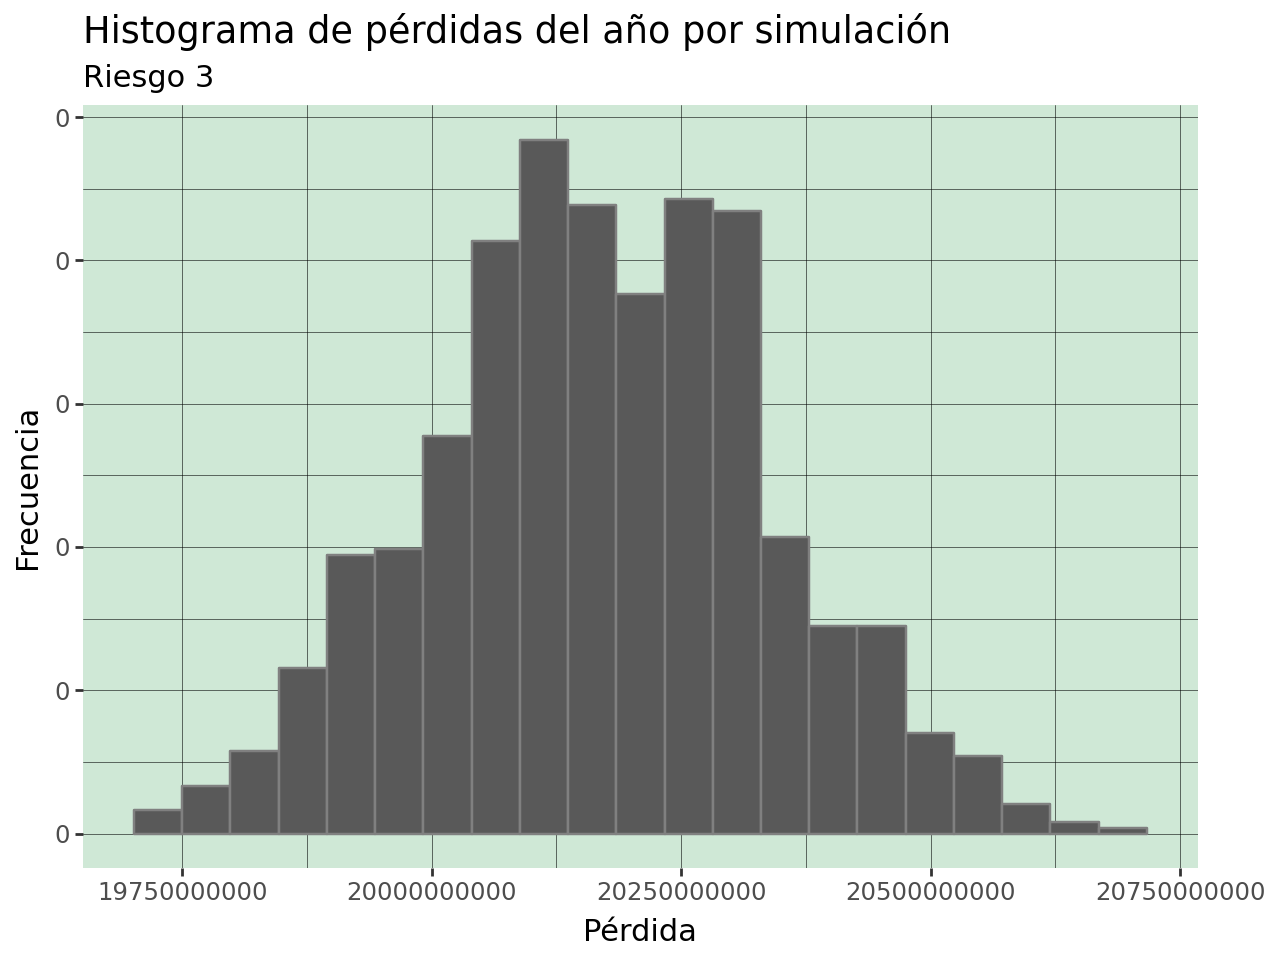

In [64]:
# Histograma de densidad

(ggplot(data = perdidaFinal) +
 geom_histogram(mapping=aes(x='perdidaFinal', y='..density..'), color='grey') +
 labs(title="Histograma de pérdidas del año por simulación",
      subtitle='Riesgo 3',
      x="Pérdida", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

Tomaremos como umbral de severos a los valores mayores o iguales a 20500000000

In [65]:
regresionLinealSeveros = (regresionLineal >> filter(_.perdidaFinal >= 20500000000))
regresionLinealSeveros.tail()

,Numero de trayectoria,perdidaFinal,i,St,Ft,y,const
485,485,2.051274e+10,23,0.023,0.977,-3.760649,1
425,425,2.051256e+10,24,0.024,0.976,-3.717580,1
732,732,2.050448e+10,25,0.025,0.975,-3.676247,1
57,57,2.050331e+10,26,0.026,0.974,-3.636516,1
582,582,2.050170e+10,27,0.027,0.973,-3.598264,1


/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 5'. Pick better value with 'binwidth'.


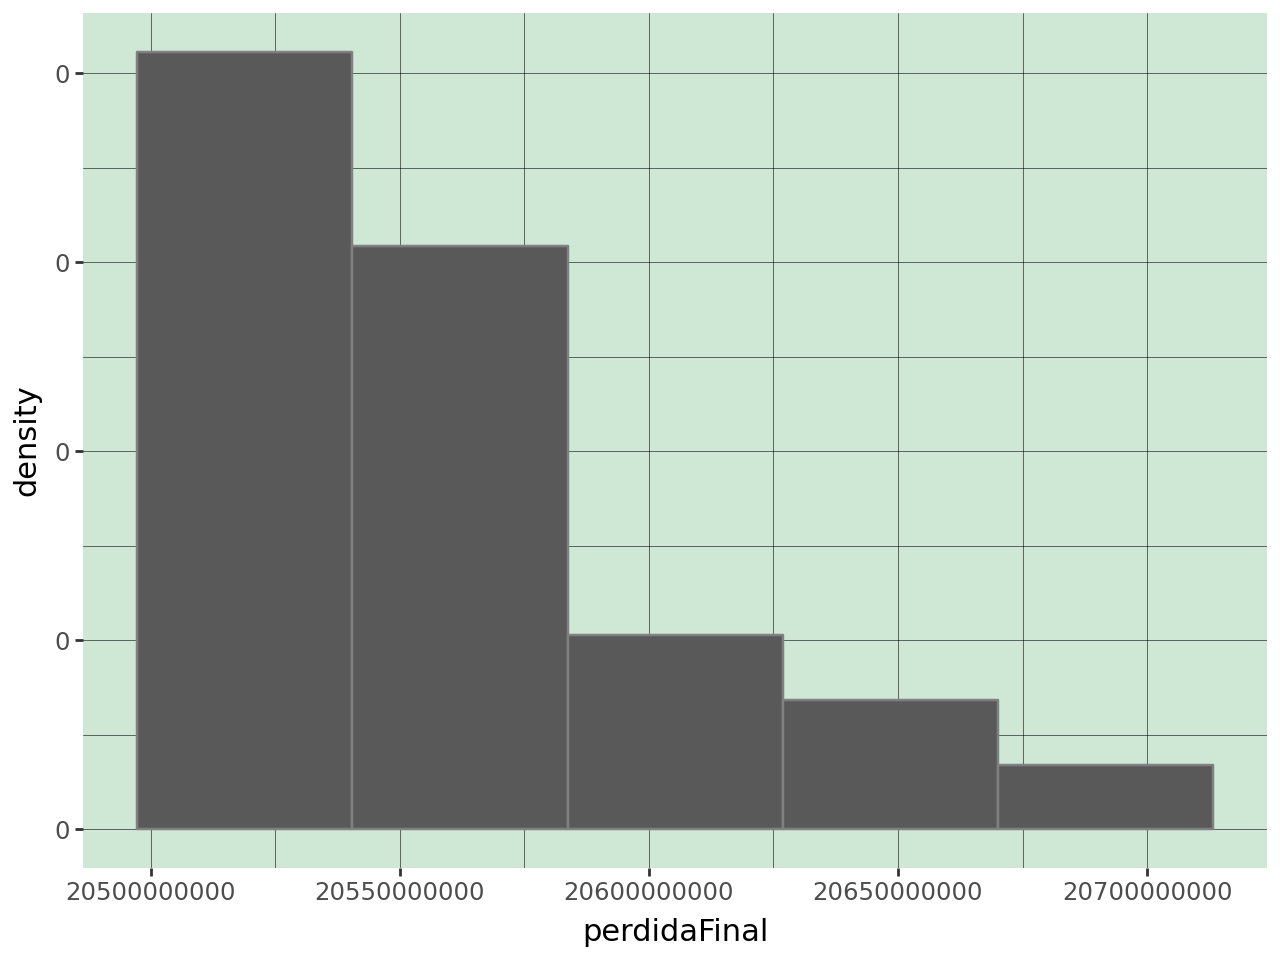

In [66]:
(ggplot() +
 geom_histogram(data = regresionLinealSeveros, mapping=aes(x='perdidaFinal', y='..density..'), color='grey') +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

In [67]:
# Hacemos la regresión lineal

predictors = ["const", "perdidaFinal"]
target = "y"
fit = sm.OLS(regresionLinealSeveros[target], regresionLinealSeveros[predictors]).fit()
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3411.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           2.98e-28
Time:                        04:04:40   Log-Likelihood:                 33.209
No. Observations:                  27   AIC:                            -62.42
Df Residuals:                      25   BIC:                            -59.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          375.9153      6.514     57.710      0.000     362.500     389.331
perdidaFinal -1.851e-08   3.17e-10    -58.402      0.000   -1.92e-08   -1.79e-08
==============================================================================
Omnibus:                        3.967   Durbin-Watson:                   0.929
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                2.499
Skew:                          -0.711   Prob(JB):                        0.287
Kurtosis:                       3.449   Cond. No.                     9.47e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.47e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
betas = fit.params
lambGumbel = -1/betas[1]
muGumbel = -betas[0]/betas[1]

print(f"lambda={lambGumbel}\nmu={muGumbel}")

lambda=54033185.48415679
mu=20311902419.13288


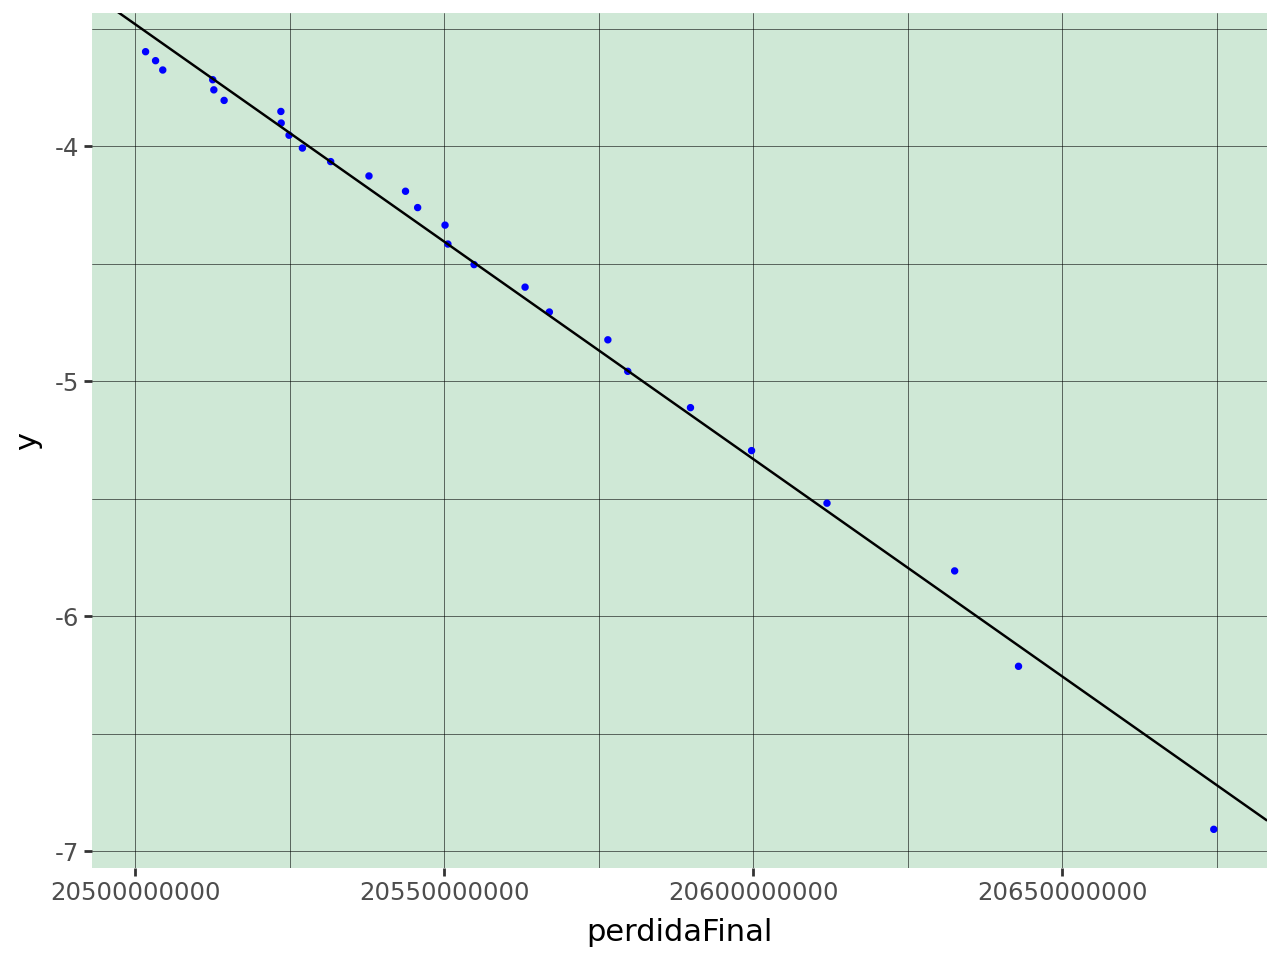

In [69]:
(ggplot(regresionLinealSeveros) +
 geom_point(mapping=aes(x='perdidaFinal', y='y'), color='blue', size=0.5) +
 geom_abline(intercept=betas[0], slope=betas[1]) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

In [70]:
# Calculo del TVaR

lambGumbel = 54033185.48415679
muGumbel = 20311902419.13288
gamma = 0.57721566

muGumbel + lambGumbel*gamma

20343091219.95402

# Valores extremos en un mes

In [71]:
a = 2
b = 3

SimulacionesAcotadas = (SimulacionesPerdidas >>
                        select(-_.SeveridadAcumulada) >> # Quitamos las severidades acumuladas
                        filter((_.Trayectorias > a) & (_.Trayectorias < b))) # Tomamos solo los eventos que ocurrieron en el periodo [a,b]

### Añadimos la nueva severidad acumulada ###

NoTrayectorias = SimulacionesAcotadas['Numero de trayectoria'].max() + 1 # Obtenemos el numero de trayectorias

SimulacionesPerdidasAcotadas = pd.DataFrame() # Creamos un dataframe vacio para almacenar las trayectorias

# A cada trayectoria le agregaremos una columna con la severidad por evento y la severidad acumulada
for i in range(NoTrayectorias+1): # Sumamos 1 por el slicing
  # Filtramos por el numero de trayectoria
  Perdida = (SimulacionesAcotadas >> filter(_['Numero de trayectoria'] == i))
  # Agregamos una severidad a cada evento y posteriormente hacemos la suma acumulada de severidades
  Perdida = (Perdida >> mutate(Severidad = simulacionDistEmpirica(len(Perdida))) >> mutate(SeveridadAcumulada = _.Severidad.cumsum()))
  SimulacionesPerdidasAcotadas = pd.concat([SimulacionesPerdidasAcotadas, Perdida])

SimulacionesPerdidasAcotadas

,Trayectorias,Conteos,Numero de trayectoria,Severidad,SeveridadAcumulada
6003,2.002665,6004,0,1.208509e+06,1.208509e+06
6004,2.005544,6005,0,8.690787e+05,2.077587e+06
6005,2.005565,6006,0,1.215073e+06,3.292660e+06
6006,2.008522,6007,0,2.220384e+06,5.513044e+06
6007,2.009110,6008,0,1.091632e+06,6.604676e+06
...,...,...,...,...,...
17336126,2.984863,6467,999,6.964016e+05,6.793463e+08
17336127,2.988815,6468,999,7.893928e+05,6.801357e+08
17336128,2.993013,6469,999,1.358726e+06,6.814944e+08
17336129,2.997371,6470,999,1.984503e+06,6.834789e+08


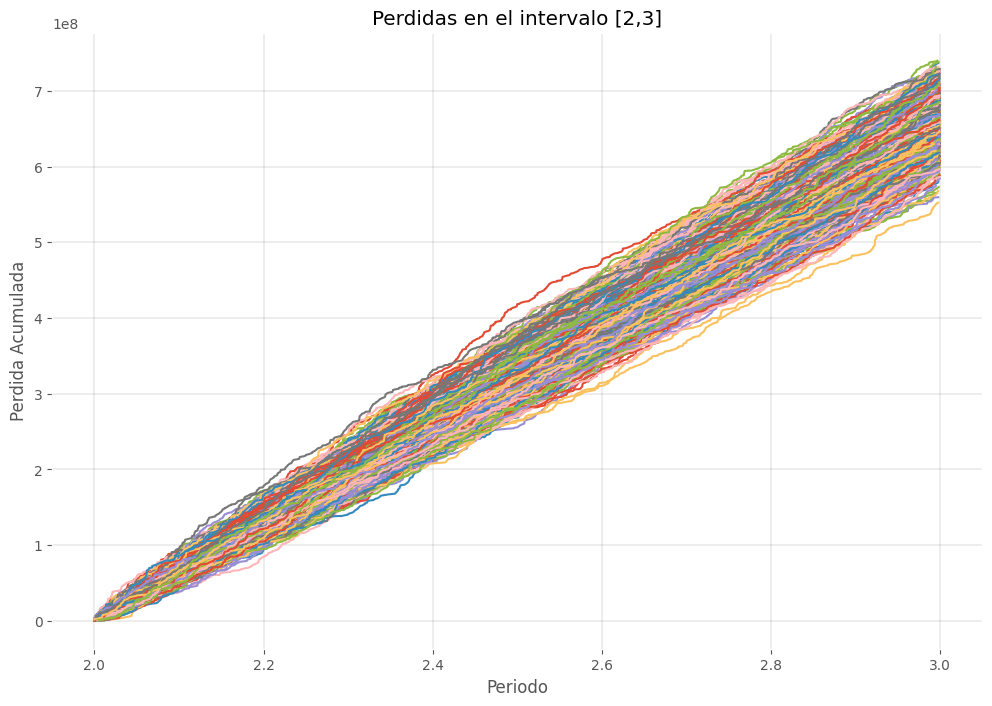

In [72]:
# Volvemos a graficar
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))

# Agrupar por 'Numero de trayectoria' y hacer un gráfico de líneas para cada trayectoria
for trayectoria, datos in SimulacionesPerdidasAcotadas.groupby('Numero de trayectoria'):
    plt.plot(datos['Trayectorias'], datos['SeveridadAcumulada'], label=f'Trayectoria {trayectoria}')

# Añadir etiquetas y título
plt.gca().set_facecolor("white") # Fondo
plt.grid(color='black', linewidth=0.1) #Cuadricula
plt.xlabel('Periodo')
plt.ylabel('Perdida Acumulada')
plt.title(f'Perdidas en el intervalo [{a},{b}]')
plt.show()

In [73]:
# Perdida final del periodo

perdidaFinalAcotada = (SimulacionesPerdidasAcotadas >> group_by(_['Numero de trayectoria']) >> summarize(perdidaFinal = _.SeveridadAcumulada.max()))
perdidaFinalAcotada

,Numero de trayectoria,perdidaFinal
0,0,6.335925e+08
1,1,7.366971e+08
2,2,6.185532e+08
3,3,7.127018e+08
4,4,6.042145e+08
...,...,...
995,995,6.431729e+08
996,996,6.330018e+08
997,997,6.796238e+08
998,998,6.458991e+08


/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.


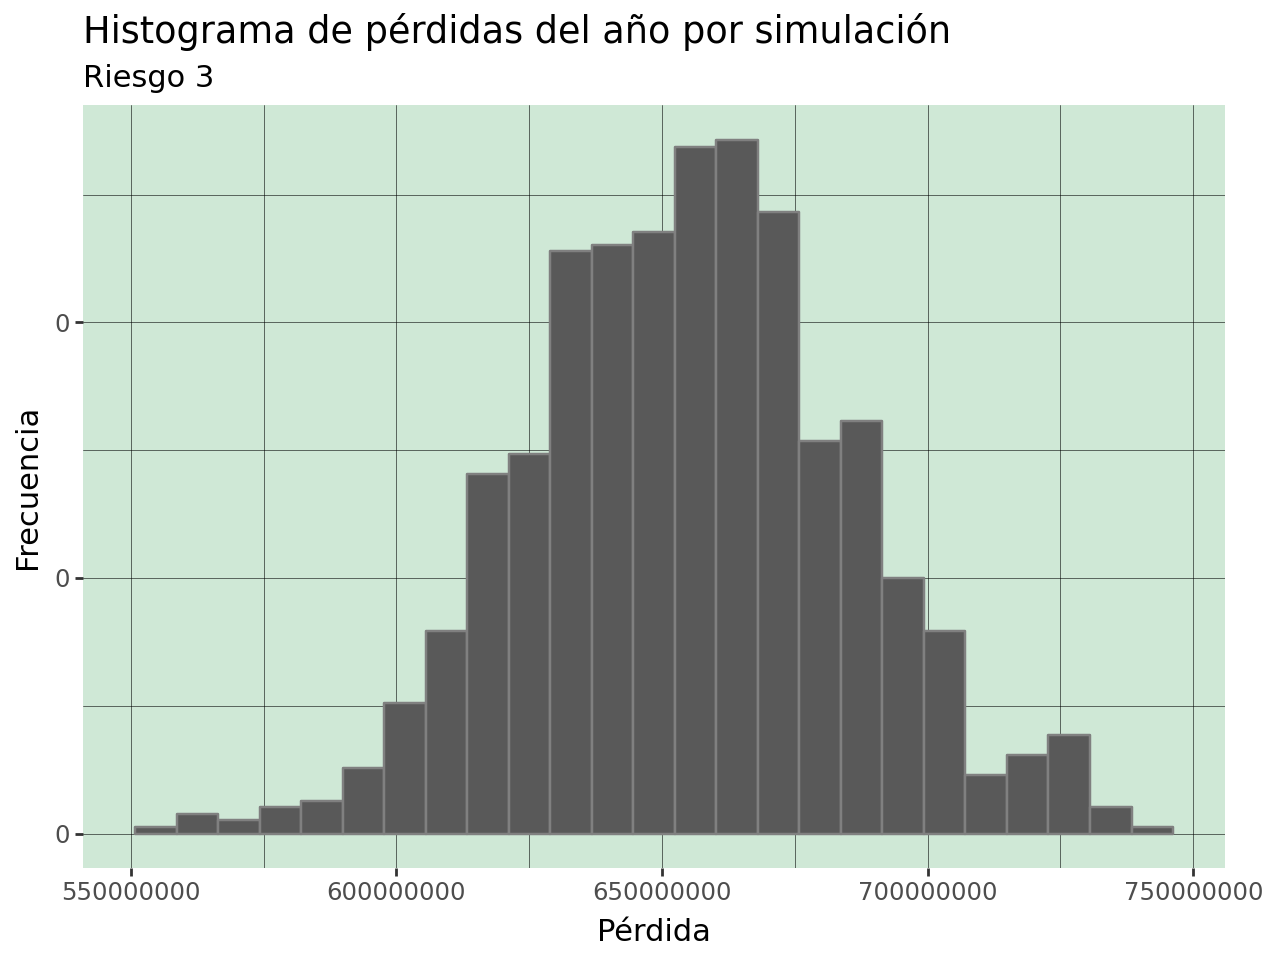

In [74]:
# Histograma de densidad

(ggplot(data = perdidaFinalAcotada) +
 geom_histogram(mapping=aes(x='perdidaFinal', y='..density..'), color='grey') +
 labs(title="Histograma de pérdidas del año por simulación",
      subtitle='Riesgo 3',
      x="Pérdida", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

,Numero de trayectoria,perdidaFinal,i,St,Ft,y,const
585,585,5.679964e+08,996,0.996,4.000000e-03,1.708642,1
537,537,5.656478e+08,997,0.997,3.000000e-03,1.759433,1
40,40,5.642859e+08,998,0.998,2.000000e-03,1.826903,1
324,324,5.595420e+08,999,0.999,1.000000e-03,1.932645,1
501,501,5.523331e+08,1000,1.000,1.110223e-16,3.603779,1


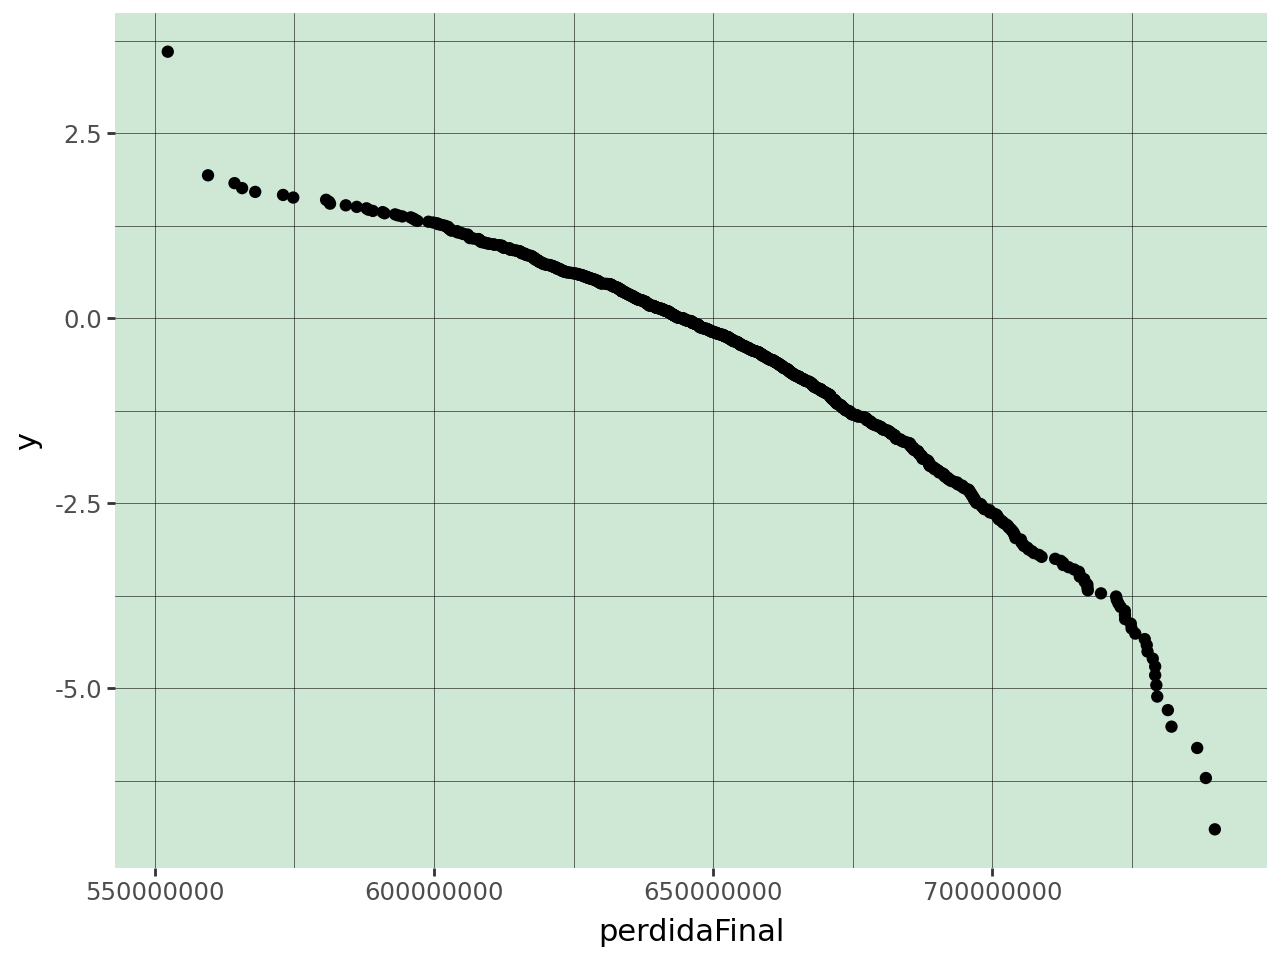

In [75]:
# Construimos la funcion de distribucion acumulada

n=perdidaFinal.shape[0]

regresionLineal = (perdidaFinalAcotada >>
                   arrange(-_.perdidaFinal) >>
                   mutate(i=range(1, n+1),
                          St=_.i/(n+0.0000000000001), # sumamos 1*10^{-13} porque en la perdida mas grande Ft da infinito
                          Ft = 1-_.St,
                          y = np.log(-np.log(_.Ft)),
                          const = 1,)
                   )

display(regresionLineal.tail())

(ggplot(regresionLineal) +
 geom_point(aes(x='perdidaFinal', y='y')) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

Tomaremos como umbral de severos a los valores mayores o iguales a 72500000

In [76]:
regresionLinealSeveros = (regresionLineal >> filter(_.perdidaFinal >= 725000000))
regresionLinealSeveros.tail()

,Numero de trayectoria,perdidaFinal,i,St,Ft,y,const
801,801,7.287386e+08,10,0.010,0.990,-4.600149,1
460,460,7.277952e+08,11,0.011,0.989,-4.504335,1
496,496,7.276607e+08,12,0.012,0.988,-4.416818,1
222,222,7.273050e+08,13,0.013,0.987,-4.336270,1
8,8,7.256028e+08,14,0.014,0.986,-4.261657,1


In [77]:
predictors = ["const", "perdidaFinal"]
target = "y"
fit = sm.OLS(regresionLinealSeveros[target], regresionLinealSeveros[predictors]).fit()
display(fit.summary())

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     235.1
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           3.02e-09
Time:                        04:05:00   Log-Likelihood:                 5.3766
No. Observations:                  14   AIC:                            -6.753
Df Residuals:                      12   BIC:                            -5.475
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          122.2280      8.305     14.718      0.000     104.134     140.322
perdidaFinal -1.742e-07   1.14e-08    -15.333      0.000   -1.99e-07   -1.49e-07
==============================================================================
Omnibus:                        0.886   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.642   Jarque-Bera (JB):                0.662
Skew:                          -0.006   Prob(JB):                        0.718
Kurtosis:                       1.935   Cond. No.                     1.28e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
betas = fit.params
lambGumbel = -1/betas[1]
muGumbel = -betas[0]/betas[1]

print(f"lambda={lambGumbel}\nmu={muGumbel}")

lambda=5740133.880892321
mu=701604800.2280623


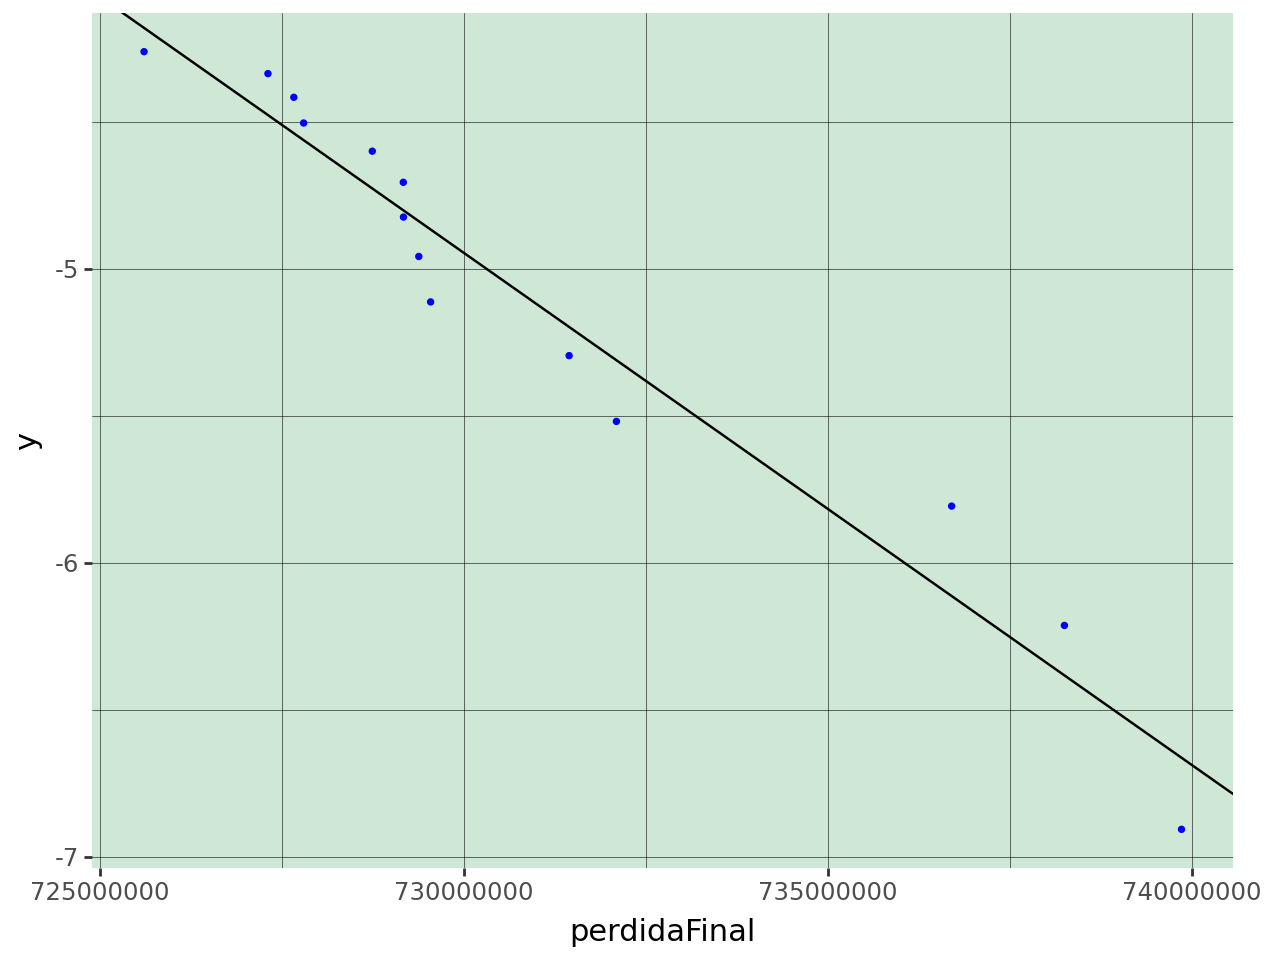

In [79]:
(ggplot(regresionLinealSeveros) +
 geom_point(mapping=aes(x='perdidaFinal', y='y'), color='blue', size=0.5) +
 geom_abline(intercept=betas[0], slope=betas[1]) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

# Riesgo 1 (Lognormal)

In [80]:
# Parametros de la distribucion Lognormal
n = 100000
perdidaMedia = 650000
sdPerdida = 1.62

# Generacion de la Lognormal
np.random.seed(2024)
incidentes2 = np.random.lognormal(mean=np.log(perdidaMedia), sigma=np.log(sdPerdida), size = n)

In [81]:
# Funcion para el segundo proceso poisson compuesto

def parametrosPoisson2(mes):
  mediaMes1 = 6000
  mediaMes2 = 5000
  mediaMes3 = 2000
  mediaMes4 = 20
  mediaMes5 = 10
  mediaMes6 = 40
  mediaMes7 = 45
  mediaMes8 = 30
  mediaMes9 = 400
  mediaMes10 = 3500
  mediaMes11 = 3000
  mediaMes12 = 3000
  if mes <= 1:
    return mediaMes1
  elif mes <= 2:
    return mediaMes2
  elif mes <= 3:
    return mediaMes3
  elif mes <= 4:
    return mediaMes4
  elif mes <= 5:
    return mediaMes5
  elif mes <= 6:
    return mediaMes6
  elif mes <= 7:
    return mediaMes7
  elif mes <= 8:
    return mediaMes8
  elif mes <= 9:
    return mediaMes9
  elif mes <= 10:
    return mediaMes10
  elif mes <= 11:
    return mediaMes11
  elif mes <= 12:
    return mediaMes12

parametrosPoissonVectorizada2 = np.vectorize(parametrosPoisson2)

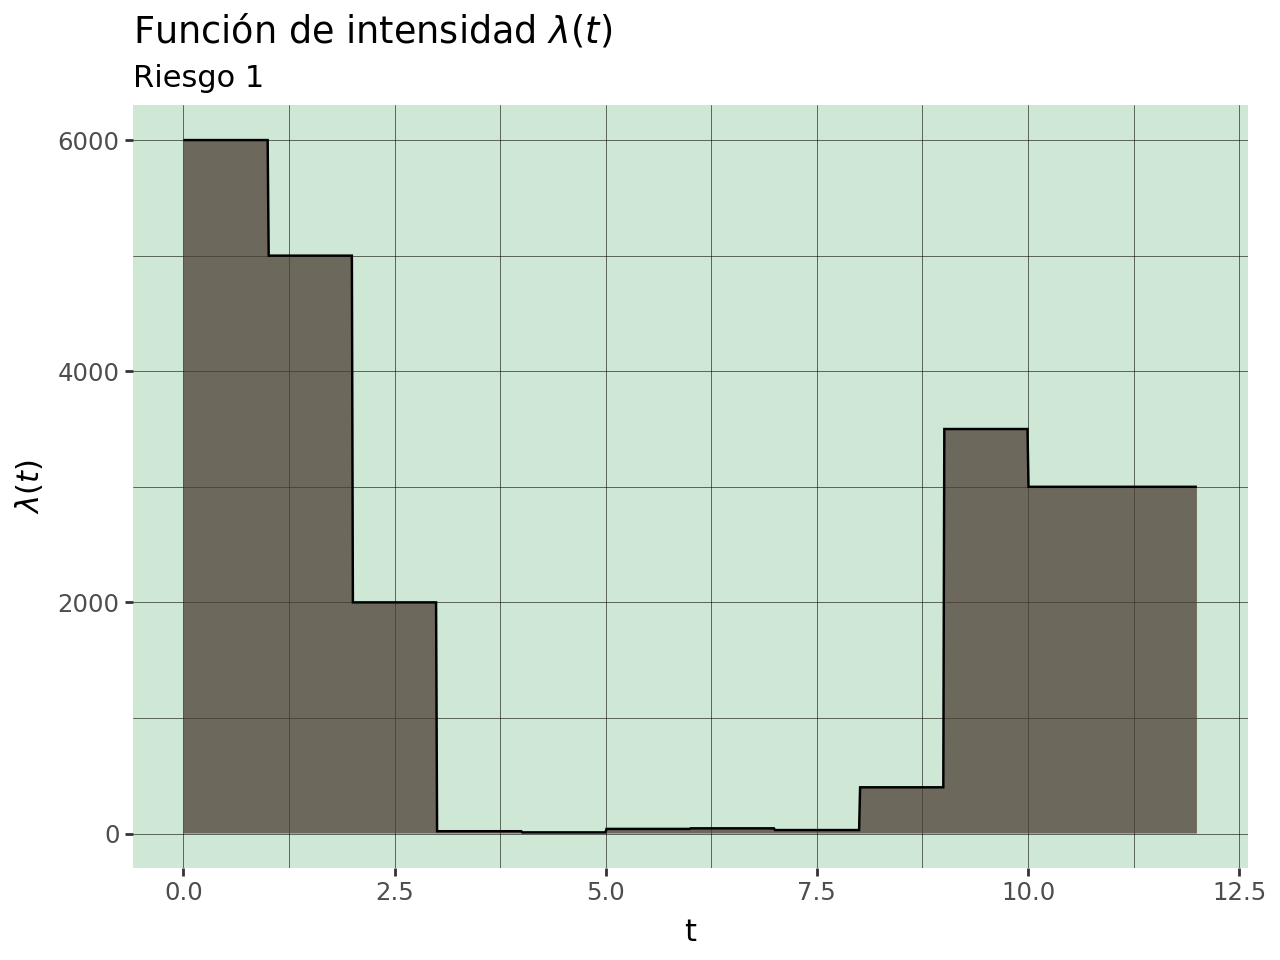

In [82]:
valoresX = np.linspace(0,12,1000)
valoresY = parametrosPoissonVectorizada2(valoresX)

(ggplot()+
 geom_area(mapping=aes(x=valoresX, y=valoresY), color='black', fill='#4B3D33', alpha=0.75, size=0.5) +
 labs(title="Función de intensidad $\lambda(t)$", subtitle='Riesgo 1', x="t", y="$\lambda(t)$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

In [83]:
# Funcion Lambda para el proceso poisson no homogeneo

def parametrosPoissonAcumulados2(mes):
  mediaMes1 = 6000
  mediaMes2 = 5000
  mediaMes3 = 2000
  mediaMes4 = 20
  mediaMes5 = 10
  mediaMes6 = 40
  mediaMes7 = 45
  mediaMes8 = 30
  mediaMes9 = 400
  mediaMes10 = 3500
  mediaMes11 = 3000
  mediaMes12 = 3000
  if mes <= 1:
    return mediaMes1
  elif mes <= 2:
    return mediaMes1 + mediaMes2
  elif mes <= 3:
    return mediaMes1 + mediaMes2 + mediaMes3
  elif mes <= 4:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4
  elif mes <= 5:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5
  elif mes <= 6:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6
  elif mes <= 7:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7
  elif mes <= 8:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8
  elif mes <= 9:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9
  elif mes <= 10:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9 + mediaMes10
  elif mes <= 11:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9 + mediaMes10 + mediaMes11
  elif mes <= 12:
    return mediaMes1 + mediaMes2 + mediaMes3 + mediaMes4 + mediaMes5 + mediaMes6 + mediaMes7 + mediaMes8 + mediaMes9 + mediaMes10 + mediaMes11 + mediaMes12


parametrosPoissonAcumuladosVectorizada2 = np.vectorize(parametrosPoissonAcumulados2)

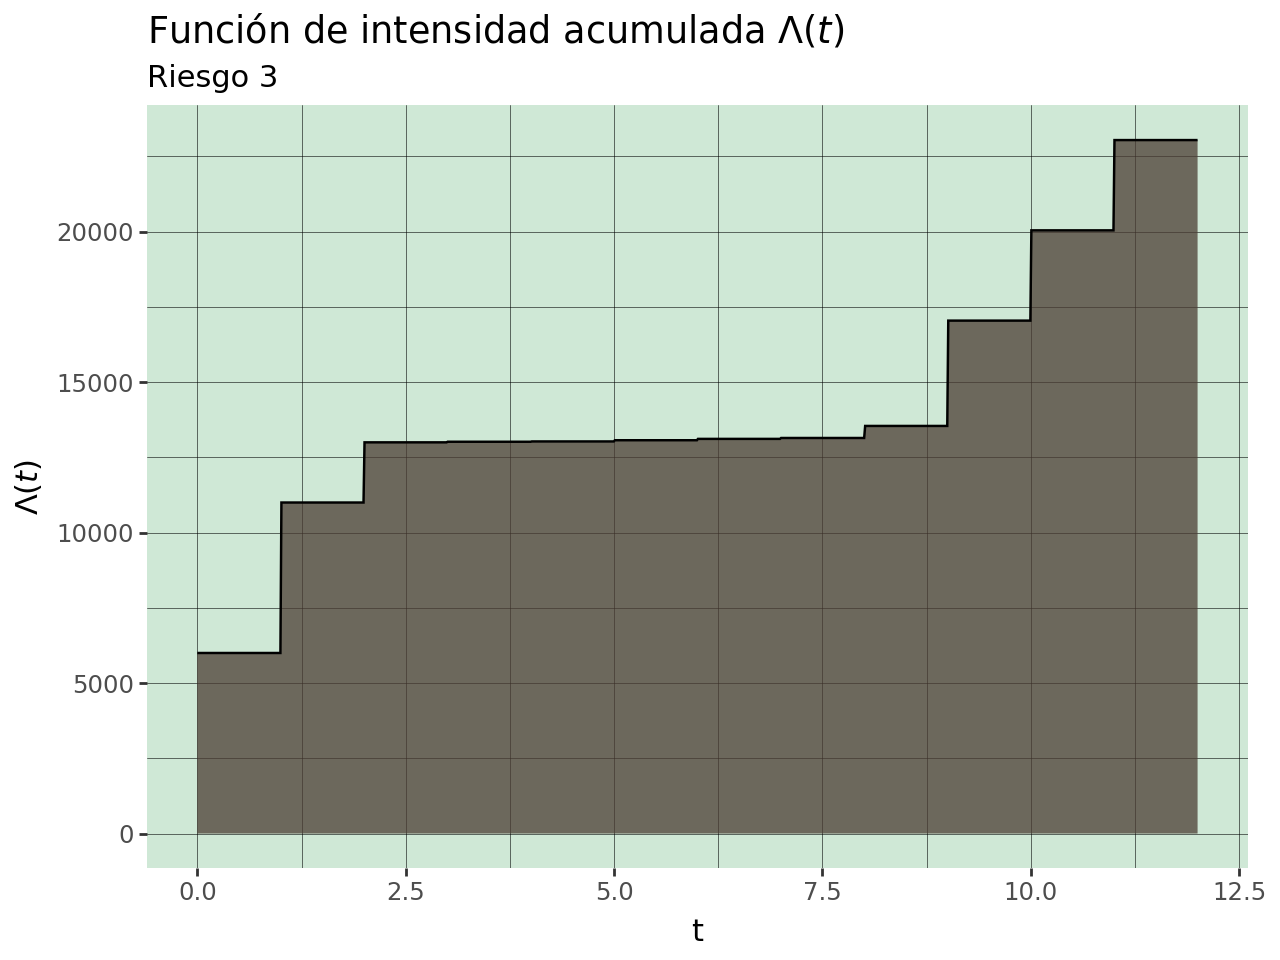

In [84]:
valoresXacumulados = np.linspace(0,12,1000)
valoresYacumulados = parametrosPoissonAcumuladosVectorizada2(valoresX)

(ggplot()+
 geom_area(mapping=aes(x=valoresXacumulados, y=valoresYacumulados), color='black', fill='#4B3D33', alpha=0.75, size=0.5) +
 labs(title="Función de intensidad acumulada $\Lambda(t)$", subtitle='Riesgo 3', x="t", y="$\Lambda(t)$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
)

### Simular el proceso Poisson no homogeneo
$ X_t \sim Poisson(\Lambda (t)) $

Método de cambio de tiempo
*   Simula un proceso $Poisson(\lambda^*)$
*   Para cada observación simula  $U_i(t)∼U[0,1]$
*   Si  $U_i ≤ \frac{λ(t)}{λ^*}$  acepto, si no, rechazo

En este caso $\lambda(t)$ es una función a trozos definida por\
$\lambda:[0,12] \longrightarrow [0, \infty]$

$ \lambda(t) =
\begin{cases}
\text{6000} & \text{si } t \leq 1 \\
\text{5000} & \text{si } 1 < t \leq 2 \\
\text{2000} & \text{si } 2 < t \leq 3 \\
\text{20} & \text{si } 3 < t \leq 4 \\
\text{10} & \text{si } 4 < t \leq 5 \\
\text{40} & \text{si } 5 < t \leq 6 \\
\text{45} & \text{si } 6 < t \leq 7 \\
\text{30} & \text{si } 7 < t \leq 8 \\
\text{400} & \text{si } 8 < t \leq 9 \\
\text{3500} & \text{si } 9 < t \leq 10 \\
\text{3000} & \text{si } 10 < t \leq 11 \\
\text{3000} & \text{si } 11 < t \leq 12
\end{cases} $

Acotaremos $\lambda(t)$ con $\lambda^*=max\{ \lambda(t) \} = 6000$

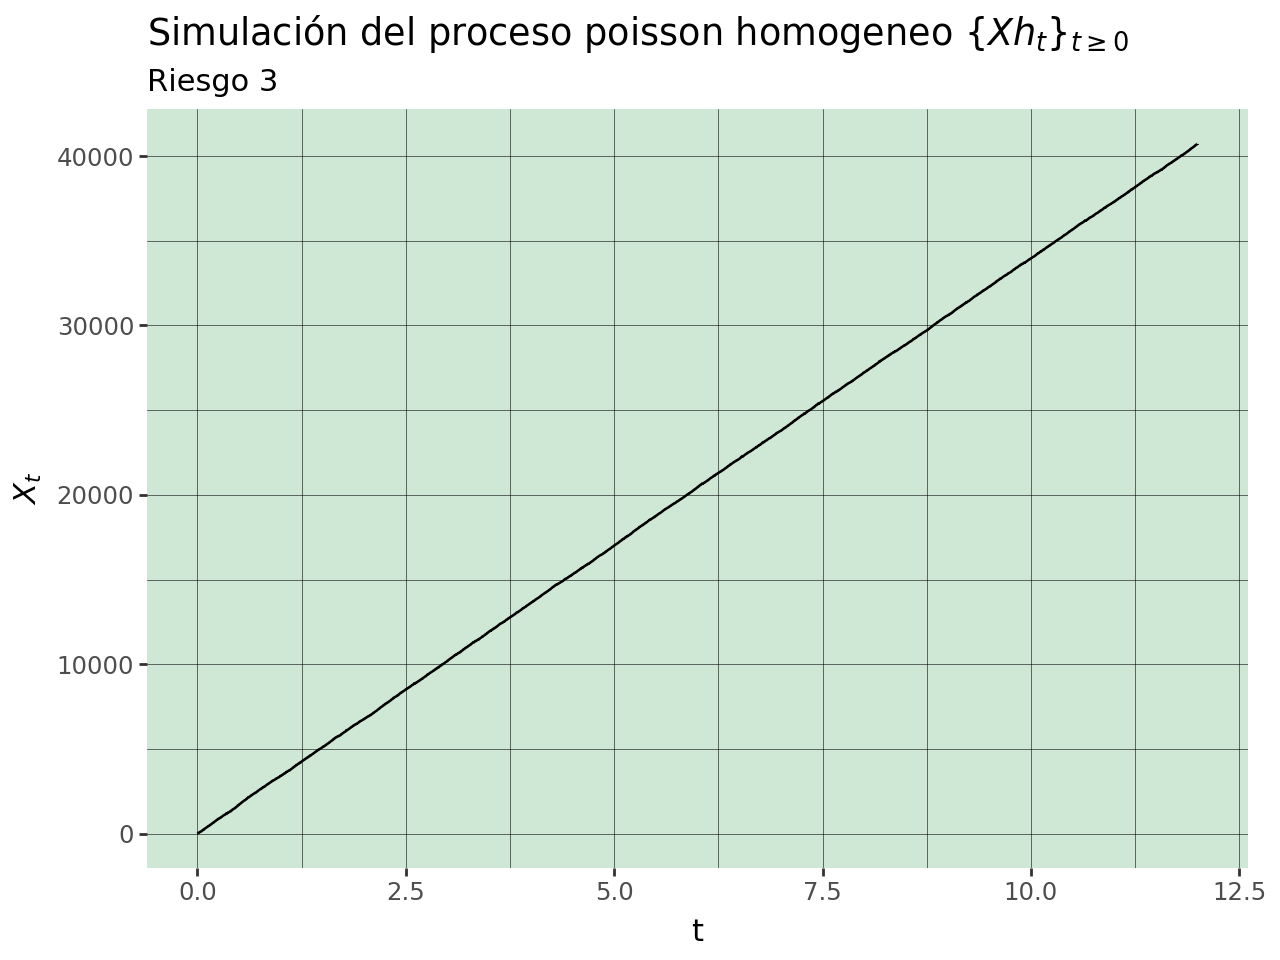

In [85]:
# Llamamos al proceso poisson homogeneo
lambdaEstrella2 = 6000
np.random.seed(2024)
t, Xt = procesoPoissonHom(lambdaEstrella, 12)

# Funcion Lambda(t)
x = np.linspace(0,12)
y = lambdaEstrella*x

(ggplot() +
 #geom_point(mapping=aes(x=t, y=Xt), color="red") +
 geom_step(mapping=aes(x=t, y=Xt)) +
 #geom_line(mapping=aes(x=x,y=y)) +
 labs(title='Simulación del proceso poisson homogeneo $\{Xh_t\}_{t \geq 0}$', subtitle='Riesgo 3', x="t", y="$X_t$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

## Simulamos el proceso Poisson no homogeneo

In [86]:
# Funcion que simula el proceso poisson no homogeneo

def procesoPoissonNoHom2(T):
  valoresX = np.linspace(0,T)
  poisHom, Xt = procesoPoissonHom(lambdaEstrella2, T)
  t = []
  for poisson in poisHom:
    u = np.random.uniform()
    if u <= (parametrosPoissonVectorizada2(poisson) / parametrosPoissonVectorizada2(T)):
      t.append(poisson)
  Xt = np.arange(1, len(t)+1)
  return t, Xt

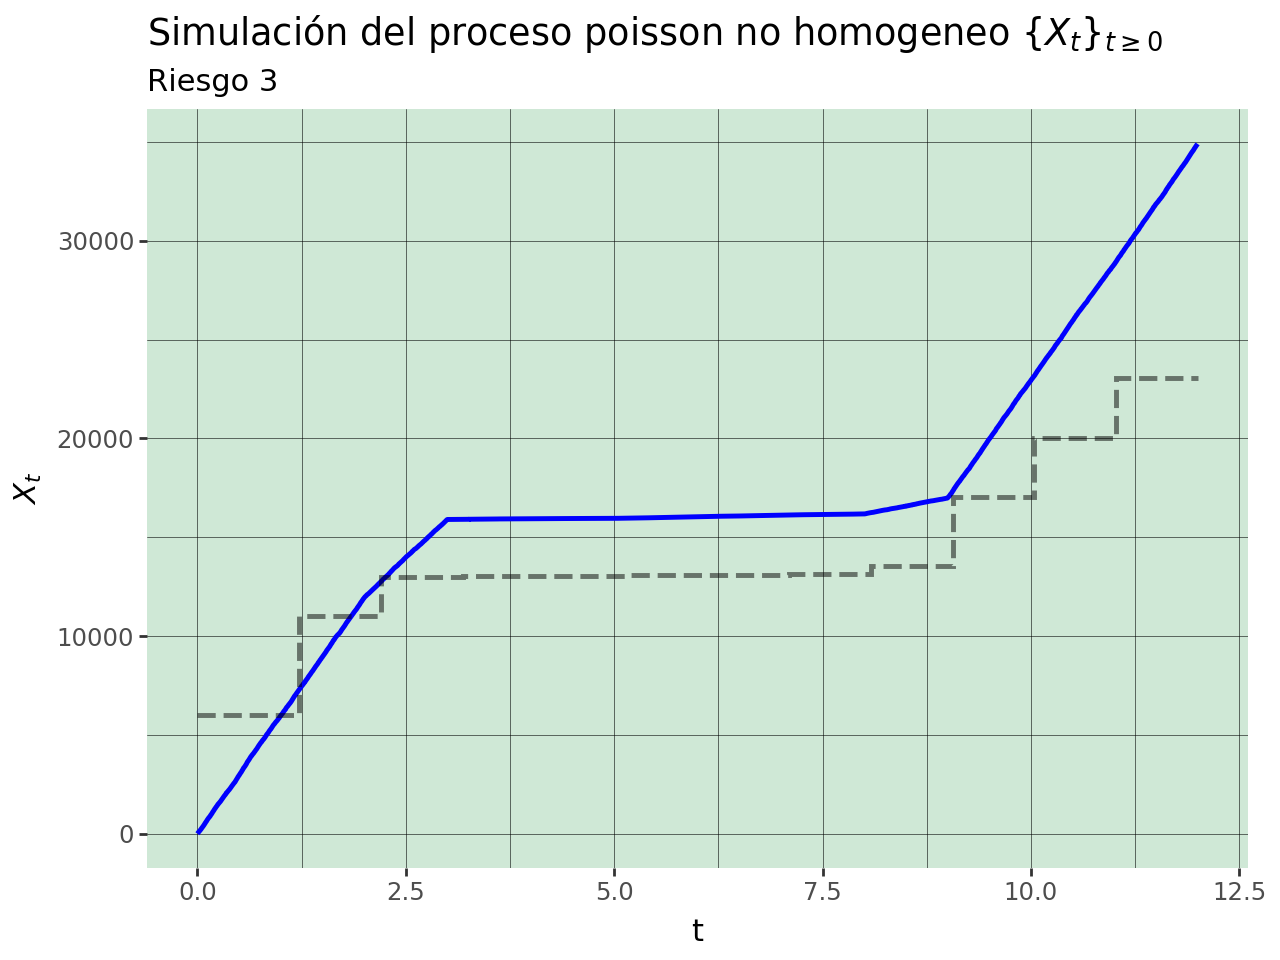

In [87]:
# Llamar a la funcion que simula el proceso poisson no homogeneo
np.random.seed(2024)
t, Xt = procesoPoissonNoHom2(12)

# Trayectoria del proceso poisson no homogeneo
x = np.linspace(0,12)
y = parametrosPoissonAcumuladosVectorizada2(x)

(ggplot() +
 geom_line(mapping=aes(x=t, y=Xt), color='blue', size=1) +
 geom_step(mapping=aes(x=x, y=y), linetype='dashed', size=1, alpha=0.5) +
 labs(title="Simulación del proceso poisson no homogeneo $\{X_t\}_{t \geq 0}$",
      subtitle='Riesgo 3',
      x="t", y="$X_t$") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

Generamos n trayectorias simuladas del proceso Poisson no Homogéneo por el Método de Aceptación - Rechazo

In [ ]:
########### ¡¡¡¡¡¡¡¡¡ Tarda en ejecutarse !!!!!!!!!! ###########
'''
n = 100

trayectorias = pd.DataFrame()
np.random.seed(2024)
for i in range(n):
  t, Xt = procesoPoissonNoHom2(12)
  dataFrameTemporal = pd.DataFrame({"Trayectorias":t, "Conteos":Xt, "Numero de trayectoria":[i]*len(t)})
  trayectorias = pd.concat([trayectorias, dataFrameTemporal], ignore_index=True)
'''

'\nn = 100\n\ntrayectorias = pd.DataFrame()\nnp.random.seed(2024)\nfor i in range(n):\n  t, Xt = procesoPoissonNoHom2(12)\n  dataFrameTemporal = pd.DataFrame({"Trayectorias":t, "Conteos":Xt, "Numero de trayectoria":[i]*len(t)})\n  trayectorias = pd.concat([trayectorias, dataFrameTemporal], ignore_index=True)\n'

In [ ]:
########## ¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡ Descargar el archivo en mi computadora !!!!!!!!!!!! ##########
'''
trayectorias.to_csv('trayectoriasPPNH2.csv', index=False, header=True, sep=',', encoding='utf-8')
files.download('trayectoriasPPNH2.csv')
'''

"\ntrayectorias.to_csv('trayectoriasPPNH2.csv', index=False, header=True, sep=',', encoding='utf-8')\nfiles.download('trayectoriasPPNH2.csv')\n"

In [88]:
# Importar trayectoriasPPNH
trayectorias2 = pd.read_csv("trayectoriasPPNH2.csv")

Graficamos las trayectorias simuladas

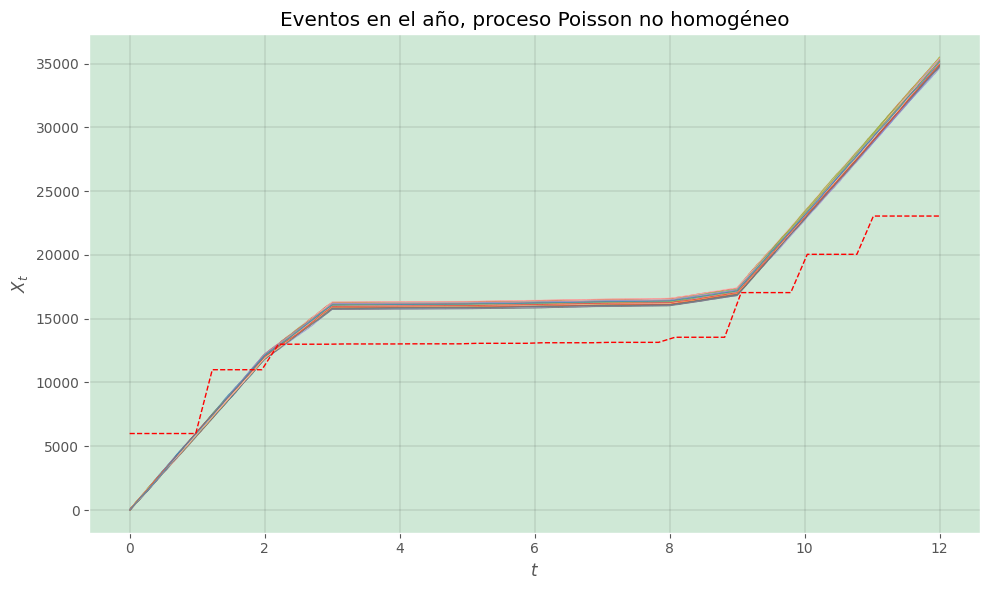

In [89]:
# Grafico de las trayectorias simuladas

# Funcion Lambda(x) = integral(lambda(t))
x = np.linspace(0,12)
y = parametrosPoissonAcumuladosVectorizada2(x)

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

# Grafico de escalera para cada simulacion
for num_trayectoria in trayectorias2['Numero de trayectoria'].unique():
    # Datos de la trayectoria actual
    df_trayectoria = trayectorias2[trayectorias2['Numero de trayectoria'] == num_trayectoria]

    # Grafico de escalera para la trayectoria actual
    plt.step(df_trayectoria['Trayectorias'], df_trayectoria['Conteos'], where='post', alpha=0.9, linewidth=0.6)

# Graficar funcion Lambda(x) = integral(lambda(t))
plt.plot(x, y, color='red', linestyle='--', linewidth=1, label='Lambda(x)')

plt.gca().set_facecolor("#cfe8d6") # Fondo
plt.grid(color='black', linewidth=0.1) #Cuadricula
plt.xlabel('$t$')
plt.ylabel('$X_t$')
plt.title('Eventos en el año, proceso Poisson no homogéneo')
plt.tight_layout()
plt.show()

# Simulamos el proceso Poisson compuesto no homogeneo
## Obtenemos un dataframe con las severidades en cada evento

In [90]:
NoTrayectorias = trayectorias2['Numero de trayectoria'].max() + 1 # Obtenemos el numero de trayectorias

SimulacionesPerdidas = pd.DataFrame() # Creamos un dataframe vacio para almacenar las trayectorias

perdidaMedia = 650000
sdPerdida = 1.62

# A cada trayectoria le agregaremos una columna con la severidad por evento y la severidad acumulada
for i in range(NoTrayectorias+1): # Sumamos 1 por el slicing
  # Filtramos por el numero de trayectoria
  Perdida = (trayectorias2 >> filter(_['Numero de trayectoria'] == i))
  # Agregamos una severidad a cada evento y posteriormente hacemos la suma acumulada de severidades
  Perdida = (Perdida >> mutate(Severidad = np.random.lognormal(mean=np.log(perdidaMedia), sigma=np.log(sdPerdida), size = len(Perdida))) >> mutate(SeveridadAcumulada = _.Severidad.cumsum()))
  SimulacionesPerdidas = pd.concat([SimulacionesPerdidas, Perdida])

SimulacionesPerdidas

,Trayectorias,Conteos,Numero de trayectoria,Severidad,SeveridadAcumulada
0,0.000211,1,0,4.504297e+05,4.504297e+05
1,0.000402,2,0,5.518682e+05,1.002298e+06
2,0.000592,3,0,3.326761e+05,1.334974e+06
3,0.000973,4,0,3.587861e+05,1.693760e+06
4,0.001210,5,0,9.946361e+05,2.688396e+06
...,...,...,...,...,...
3508356,11.998964,35102,99,1.150250e+06,2.576943e+10
3508357,11.999000,35103,99,1.254625e+06,2.577068e+10
3508358,11.999076,35104,99,9.118336e+05,2.577159e+10
3508359,11.999486,35105,99,1.236605e+06,2.577283e+10


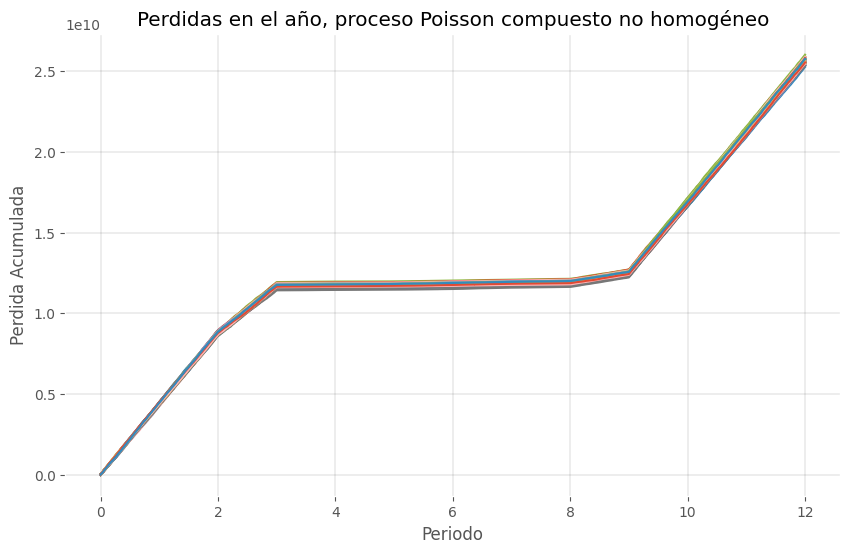

In [91]:
# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Agrupar por 'Numero de trayectoria' y hacer una gráfica de líneas para cada trayectoria
for trayectoria, datos in SimulacionesPerdidas.groupby('Numero de trayectoria'):
    plt.plot(datos['Trayectorias'], datos['SeveridadAcumulada'], label=f'Trayectoria {trayectoria}')

# Añadir etiquetas y título
plt.gca().set_facecolor("white") # Fondo
plt.grid(color='black', linewidth=0.1) #Cuadricula
plt.xlabel('Periodo')
plt.ylabel('Perdida Acumulada')
plt.title(f'Perdidas en el año, proceso Poisson compuesto no homogéneo')
plt.show()

Obtenemos la pérdida total del año en cada simulación

In [92]:
perdidaFinal2 = (SimulacionesPerdidas >> group_by(_['Numero de trayectoria']) >> summarize(perdidaFinal = _.SeveridadAcumulada.max()))
perdidaFinal2

,Numero de trayectoria,perdidaFinal
0,0,2.551122e+10
1,1,2.550625e+10
2,2,2.548260e+10
3,3,2.592228e+10
4,4,2.563061e+10
...,...,...
95,95,2.563335e+10
96,96,2.574654e+10
97,97,2.546119e+10
98,98,2.555244e+10


La media de las perdidas es: 25613781269.587597 
La desviacion estandar de las perdidas es: 147662857.98252928 


/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.
/usr/local/lib/python3.10/dist-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals


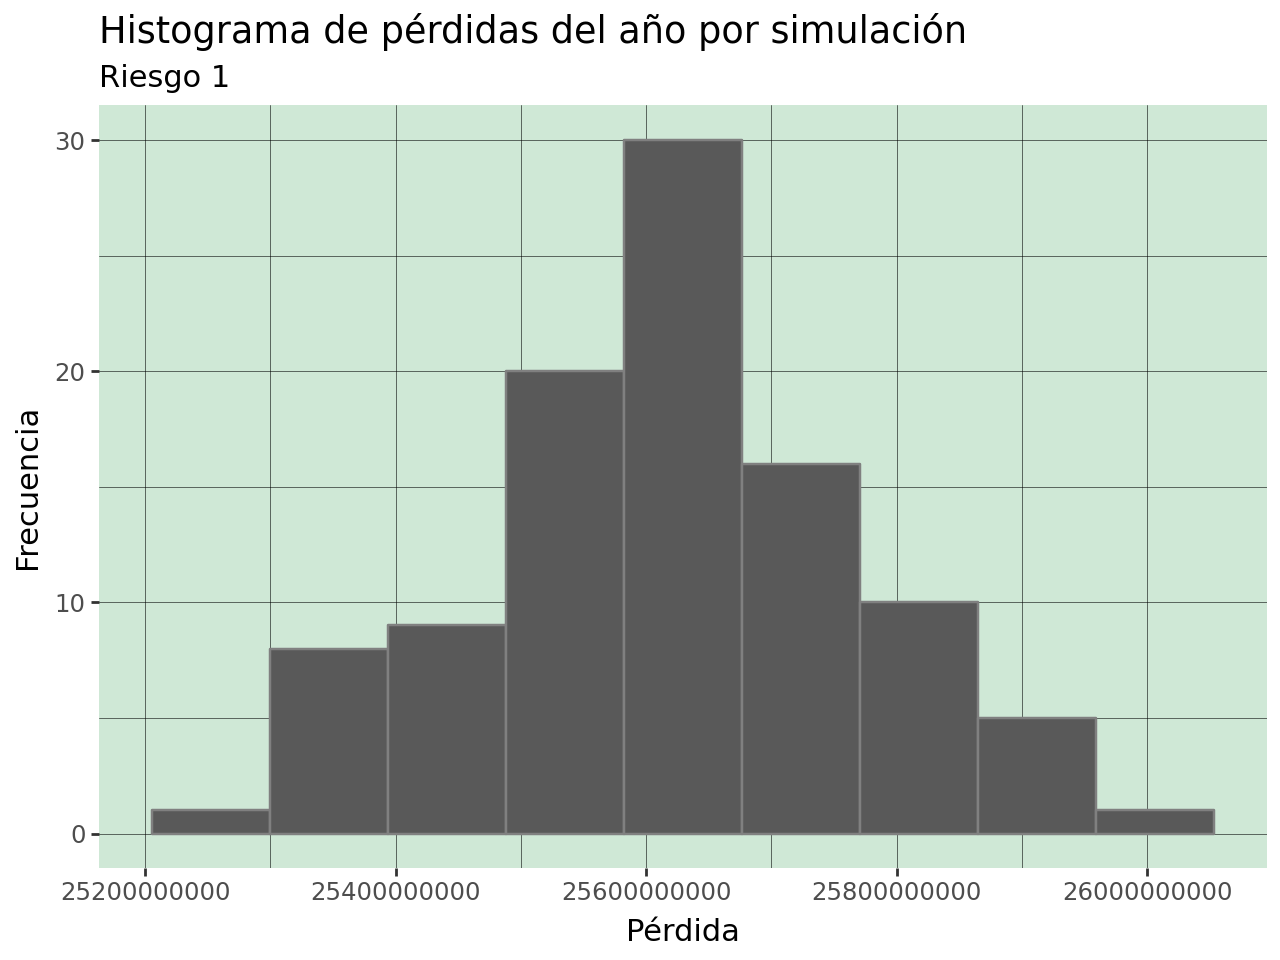

In [93]:
mediaPerdidas = np.mean(perdidaFinal2['perdidaFinal'])
sdPerdidas = np.std(perdidaFinal2['perdidaFinal'])
print(f'La media de las perdidas es: {mediaPerdidas} ')
print(f'La desviacion estandar de las perdidas es: {sdPerdidas} ')

(ggplot(data = perdidaFinal2) +
 geom_histogram(mapping=aes(x='perdidaFinal'), color='grey') +
 labs(title="Histograma de pérdidas del año por simulación",
      subtitle='Riesgo 1',
      x="Pérdida", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.
/usr/local/lib/python3.10/dist-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals


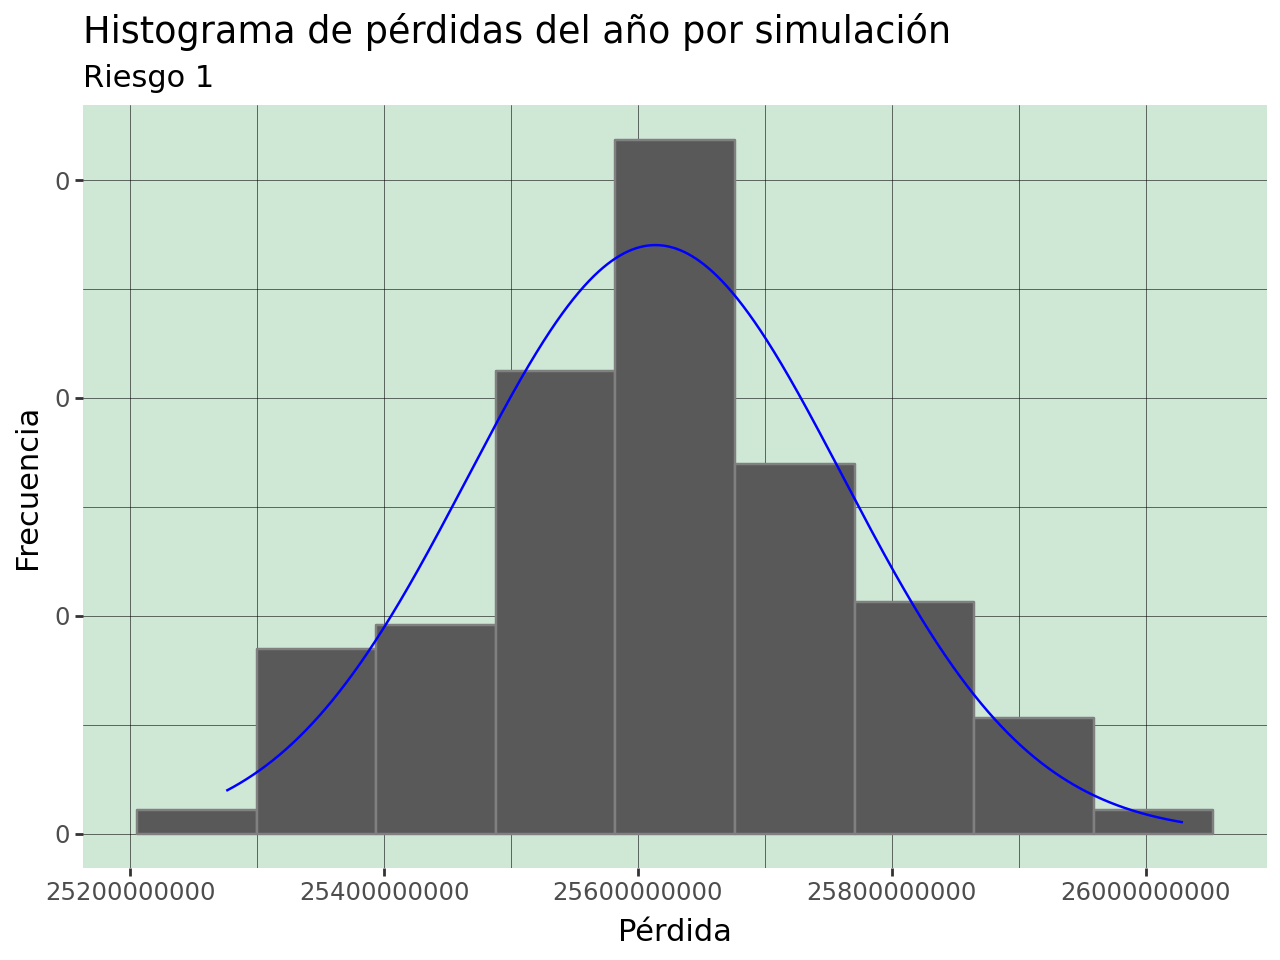

In [94]:
min = np.min(perdidaFinal2['perdidaFinal'])
max = np.max(perdidaFinal2['perdidaFinal'])
mediaPerdidas = np.mean(perdidaFinal2['perdidaFinal'])
sdPerdidas = np.std(perdidaFinal2['perdidaFinal'])

ejeX = np.linspace(min, max, 10000)
ejeY = norm.pdf(ejeX, loc=mediaPerdidas, scale=sdPerdidas)

(ggplot() +
 geom_histogram(data = perdidaFinal2, mapping=aes(x='perdidaFinal', y='..density..'), color='grey') +
 geom_line(mapping=aes(x=ejeX, y=ejeY), color='blue') +
 labs(title="Histograma de pérdidas del año por simulación",
      subtitle='Riesgo 1',
      x="Pérdida", y="Frecuencia") +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

# Prueba de bondad de ajuste Shapiro-Willks

In [95]:
stat, p_value = stats.shapiro(perdidaFinal2['perdidaFinal'])

if p_value > 0.05:
    print(f"p-valor = {p_value}, los datos siguen una distribución normal (no se rechaza H0)")
else:
    print(f"p-valor = {p_value}, los datos no siguen una distribución normal (se rechaza H0)")

p-valor = 0.8448520117560414, los datos siguen una distribución normal (no se rechaza H0)


Q-Q plot

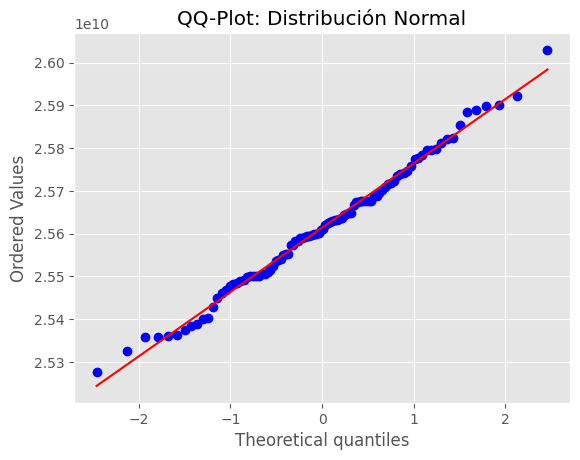

In [96]:
# Datos de ejemplo (puedes sustituirlos con tus propios datos)
normales = np.random.normal(loc=0, scale=1, size=1000)  # Ejemplo de datos normales

# Generar el QQ-plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Realizar el QQ-plot comparando los cuantiles de la normal
stats.probplot(perdidaFinal2['perdidaFinal'], dist="norm", plot=ax)

# Mostrar el gráfico
plt.title('QQ-Plot: Distribución Normal')
plt.show()

Estudio de la cola derecha

,Numero de trayectoria,perdidaFinal,i,St,Ft,y,const
66,66,2.536023e+10,96,0.96,4.000000e-02,1.169032,1
94,94,2.535872e+10,97,0.97,3.000000e-02,1.254635,1
57,57,2.535858e+10,98,0.98,2.000000e-02,1.364055,1
29,29,2.532613e+10,99,0.99,1.000000e-02,1.527180,1
22,22,2.527560e+10,100,1.00,9.992007e-16,3.542106,1


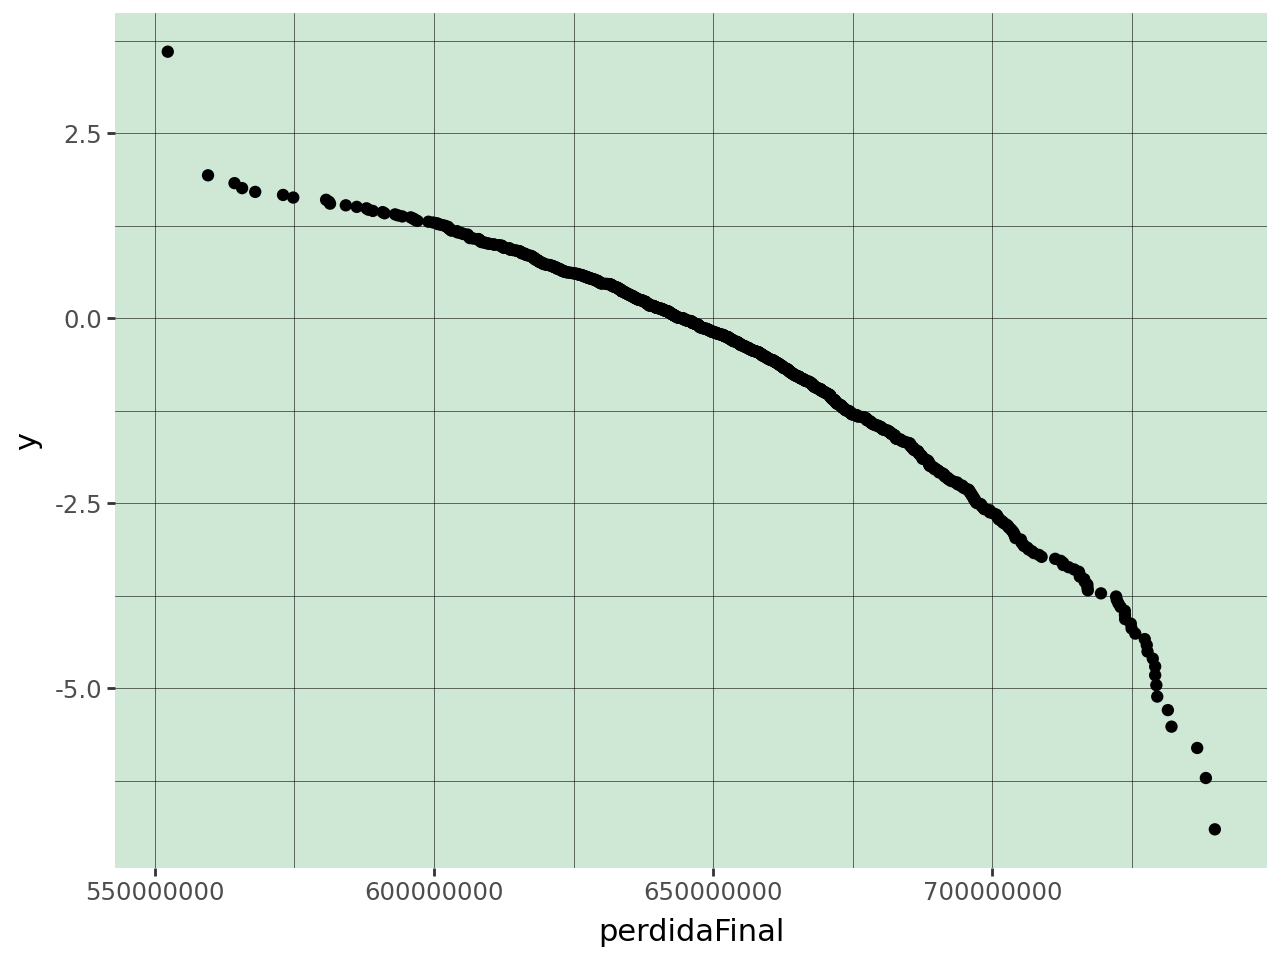

In [97]:
# Construimos la funcion de distribucion acumulada

n=perdidaFinal2.shape[0]

regresionLineal2 = (perdidaFinal2 >>
                   arrange(-_.perdidaFinal) >>
                   mutate(i=range(1, n+1),
                          St=_.i/(n+0.0000000000001), # sumamos 1*10^{-13} porque en la perdida mas grande Ft da infinito
                          Ft = 1-_.St,
                          y = np.log(-np.log(_.Ft)),
                          const = 1,)
                   )

display(regresionLineal2.tail())

(ggplot(regresionLineal) +
 geom_point(aes(x='perdidaFinal', y='y')) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

In [98]:
regresionLinealSeveros2 = (regresionLineal2 >> filter(_.perdidaFinal >= 20500000000))
regresionLinealSeveros2.tail()

,Numero de trayectoria,perdidaFinal,i,St,Ft,y,const
66,66,2.536023e+10,96,0.96,4.000000e-02,1.169032,1
94,94,2.535872e+10,97,0.97,3.000000e-02,1.254635,1
57,57,2.535858e+10,98,0.98,2.000000e-02,1.364055,1
29,29,2.532613e+10,99,0.99,1.000000e-02,1.527180,1
22,22,2.527560e+10,100,1.00,9.992007e-16,3.542106,1


/usr/local/lib/python3.10/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.
/usr/local/lib/python3.10/dist-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals


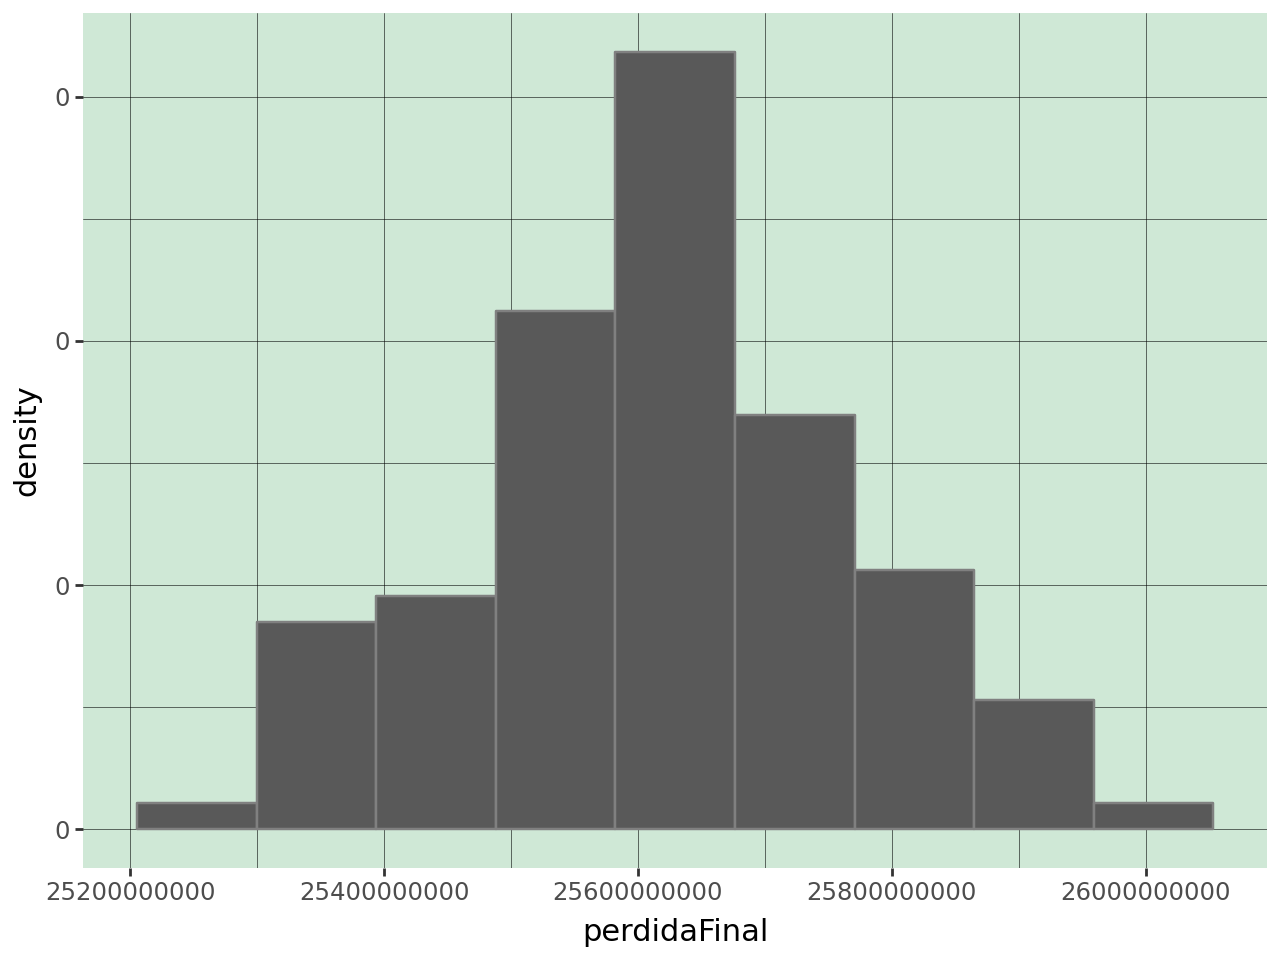

In [99]:
(ggplot() +
 geom_histogram(data = regresionLinealSeveros2, mapping=aes(x='perdidaFinal', y='..density..'), color='grey') +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2)
       )
 )

In [100]:
# Hacemos la regresión lineal

predictors = ["const", "perdidaFinal"]
target = "y"
fit = sm.OLS(regresionLinealSeveros2[target], regresionLinealSeveros2[predictors]).fit()
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     2649.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           9.48e-73
Time:                        04:05:25   Log-Likelihood:                 1.0773
No. Observations:                 100   AIC:                             1.845
Df Residuals:                      98   BIC:                             7.056
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          215.3735      4.195     51.347      0.000     207.050     223.697
perdidaFinal -8.429e-09   1.64e-10    -51.471      0.000   -8.75e-09    -8.1e-09
==============================================================================
Omnibus:                       23.400   Durbin-Watson:                   0.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.168
Skew:                           0.198   Prob(JB):                     1.51e-38
Kurtosis:                       9.453   Cond. No.                     4.44e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.44e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
betas = fit.params
lambGumbel = -1/betas[1]
muGumbel = -betas[0]/betas[1]

print(f"lambda={lambGumbel}\nmu={muGumbel}")

lambda=118641411.97313528
mu=25552221582.507153


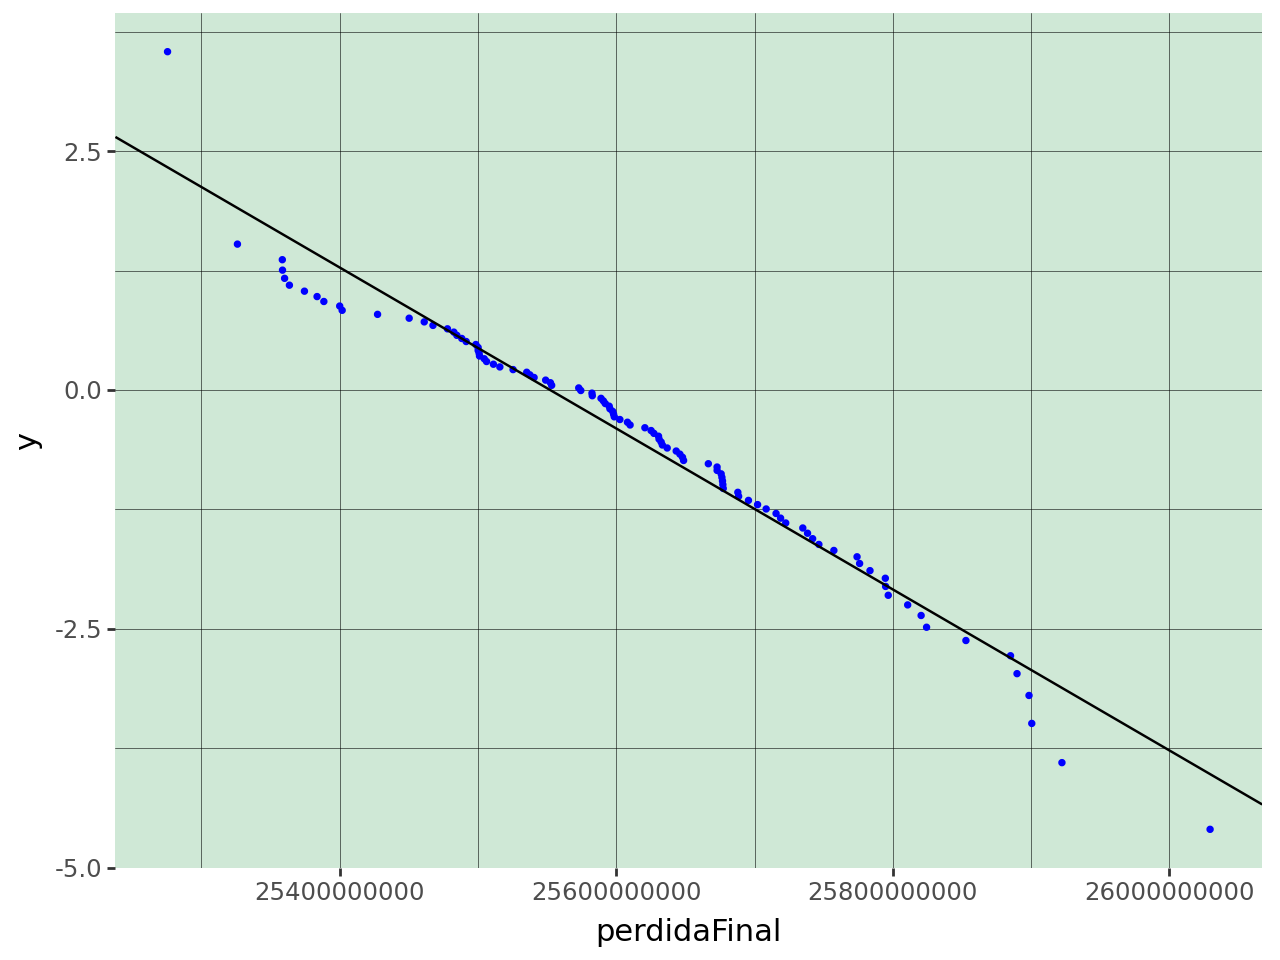

In [102]:
(ggplot(regresionLinealSeveros2) +
 geom_point(mapping=aes(x='perdidaFinal', y='y'), color='blue', size=0.5) +
 geom_abline(intercept=betas[0], slope=betas[1]) +
 theme(panel_background=element_rect(fill="#cfe8d6", color=None),
       panel_grid=element_line(color="black", size=0.2))
 )

# Cópulas

In [117]:
# Dataframe de los eventos

riesgo1 = perdidaFinal2['perdidaFinal'].tolist()
riesgo3 = perdidaFinal['perdidaFinal'].sample(n=100).tolist()

eventos = pd.DataFrame({'Riesgo1':riesgo1, 'Riesgo3':riesgo3})
eventos

,Riesgo1,Riesgo3
0,2.551122e+10,2.028611e+10
1,2.550625e+10,2.027440e+10
2,2.548260e+10,2.035134e+10
3,2.592228e+10,2.028732e+10
4,2.563061e+10,2.028170e+10
...,...,...
95,2.563335e+10,1.995748e+10
96,2.574654e+10,2.007013e+10
97,2.546119e+10,1.997042e+10
98,2.555244e+10,2.053164e+10


In [118]:
# Ajustamos la copula gaussiana

copula_gauss = GaussianMultivariate()
copula_gauss.fit(eventos)

In [119]:
# Obtenemos muestras de la copula gaussiana

muestrasConjunta = copula_gauss.sample(1000)

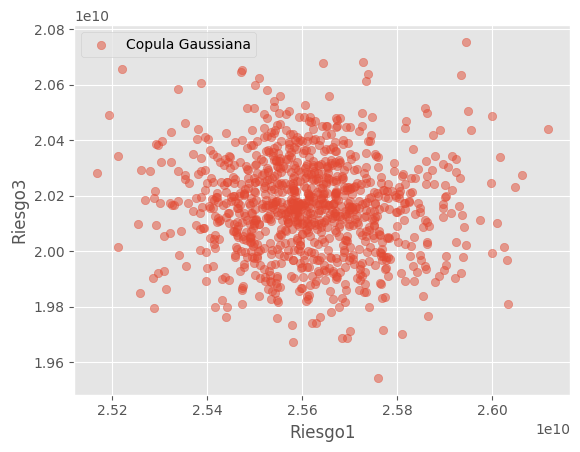

In [120]:
# Visualización de las muestras generadas

plt.scatter(muestrasConjunta['Riesgo1'], muestrasConjunta['Riesgo3'], alpha=0.5, label='Copula Gaussiana')
plt.legend()
plt.xlabel('Riesgo1')
plt.ylabel('Riesgo3')
plt.show()

## Tau de Kendal Cópula Gaussiana

Obtenemos el parámetro $\rho$ que es el coeficiente de correlación de Spearman

In [157]:
# Obtener el coefifience de correlación de Spearman

correlacion = muestrasConjunta['Riesgo1'].corr(muestrasConjunta['Riesgo3'])
correlacion

-0.054652457485888914

In [159]:
tauGauss = (2/np.pi)*np.arcsin(correlacion)
tauGauss

-0.034810178767449115

Baja correlación

# Estudiamos las colas

In [128]:
# Dataframe de las colas

riesgo1 = regresionLinealSeveros2['perdidaFinal'].sample(n=len(regresionLinealSeveros)).tolist()
riesgo3 = regresionLinealSeveros['perdidaFinal'].tolist()

colas = pd.DataFrame({'Riesgo1':riesgo1, 'Riesgo3':riesgo3})
colas

,Riesgo1,Riesgo3
0,2.548260e+10,7.398551e+08
1,2.564338e+10,7.382467e+08
2,2.562725e+10,7.366971e+08
3,2.550016e+10,7.320921e+08
4,2.568851e+10,7.314424e+08
5,2.562074e+10,7.295398e+08
6,2.536371e+10,7.293771e+08
7,2.555333e+10,7.291668e+08
8,2.555244e+10,7.291646e+08
9,2.554063e+10,7.287386e+08


In [129]:
# Ajustamos la copula de Gumbel

copula_Gumbel = Gumbel()

# Transformamos los datos a una escala uniforme
scaler = QuantileTransformer(output_distribution='uniform')
colasReescaladas = scaler.fit_transform(colas)

copula_Gumbel.fit(colasReescaladas)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (14). n_quantiles is set to n_samples.


In [144]:
# Obtenemos el parametro theta

copula_Gumbel.theta

1.6851851851851851

In [130]:
# Obtenemos muestras de la copula gaussiana

muestrasConjuntaGumbel = copula_Gumbel.sample(1000)

In [137]:
# Convertimos el resultado en un DataFrame

muestrasConjuntaGumbel = pd.DataFrame(muestrasConjuntaGumbel, columns=['Riesgo1', 'Riesgo1'])
muestrasConjuntaGumbel

,Riesgo1,Riesgo1
0,0.098507,0.843158
1,0.011726,0.014449
2,0.651352,0.670313
3,0.962263,0.764255
4,0.521898,0.831643
...,...,...
995,0.338447,0.243055
996,0.479322,0.488918
997,0.047651,0.644731
998,0.397287,0.323801


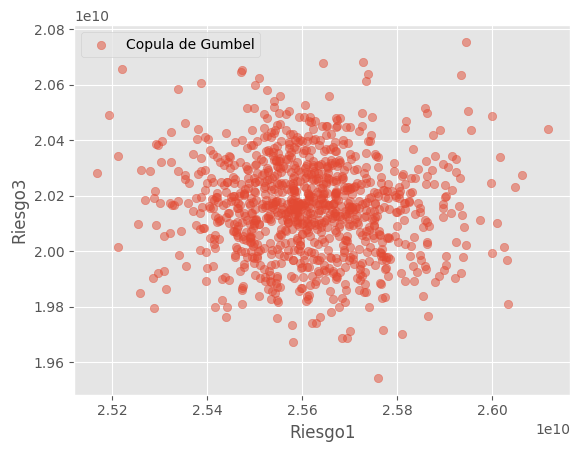

In [138]:
# Visualización de las muestras generadas

plt.scatter(muestrasConjunta['Riesgo1'], muestrasConjunta['Riesgo3'], alpha=0.5, label='Copula de Gumbel')
plt.legend()
plt.xlabel('Riesgo1')
plt.ylabel('Riesgo3')
plt.show()

# Tau de Kendall Cópula de Gumbel

In [145]:
tauGumbel = 1 - (1/copula_Gumbel.theta)
tauGumbel

0.4065934065934066

Tenemos dependencia positiva moderada

In [109]:
# Ajustamos la copula de Clayton

copula_clayton = Clayton()
copula_clayton.fit(colasReescaladas)

In [110]:
# Ajustamos la copula de Frank

copula_frank = Frank()
copula_frank.fit(colasReescaladas)
copula_frank.theta

2.1718358249317737

In [111]:
# Obtenemos muestras de la copula de Frank

muestrasConjunta = copula_frank.sample(1000)

In [112]:
muestrasConjunta

array([[0.28810021, 0.38635946],
       [0.70858798, 0.66909036],
       [0.09992784, 0.38335714],
       ...,
       [0.71015862, 0.55806913],
       [0.72632252, 0.06144487],
       [0.89281545, 0.58162372]])

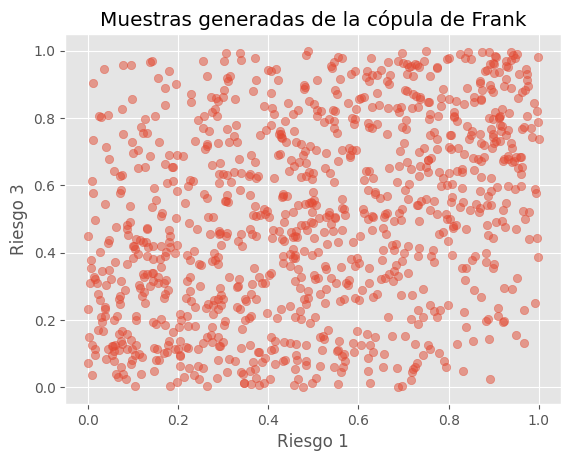

In [113]:
# Visualización de las muestras generadas

plt.scatter(muestrasConjunta[:, 0], muestrasConjunta[:, 1], alpha=0.5)
plt.title("Muestras generadas de la cópula de Frank")
plt.xlabel("Riesgo 1")
plt.ylabel("Riesgo 3")
plt.show()